# Import

In [431]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
import sklearn
import itertools
import warnings
import datetime
import os
import io
import plotly.offline as py #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization
from pylab import rcParams
from typing import Dict, List, Optional, Tuple, Union
from tqdm import tqdm
from IPython.display import Image
from category_encoders import CountEncoder
from prince import FAMD,MCA,PCA
from matplotlib.colors import ListedColormap
from matplotlib import pyplot
from optbinning import OptimalBinning
from datetime import datetime
from collections import Counter
from copy import deepcopy
from random import sample
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn import metrics
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, label_binarize
from sklearn.decomposition import PCA as skPCA, TruncatedSVD
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ParameterGrid, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.calibration import CalibratedClassifierCV, calibration_curve, _CalibratedClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier,RandomForestClassifier,BaggingClassifier,AdaBoostClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import brier_score_loss, r2_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import accuracy_score, classification_report,average_precision_score,accuracy_score
from sklearn.metrics import confusion_matrix,roc_auc_score, precision_recall_curve,roc_curve, confusion_matrix
from sklearn.metrics import classification_report, silhouette_score, log_loss
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils._testing import ignore_warnings
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from __future__ import print_function
warnings.filterwarnings("ignore")
py.init_notebook_mode(connected=True) #visualization
%matplotlib inline
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

# Data Preparation

In [214]:
#import data frame
user_data = pd.read_csv('user_data.csv',delimiter=',')
test_data = pd.read_csv('test_data.csv',delimiter=',')
order_data = pd.read_csv('order_data.csv',delimiter=',')

In [215]:
#checking whether user id in testing data exists in user_data
print('number of all user id on user data = ',len(user_data['user_id']))
print('number of unique user id on user data = ',len(user_data['user_id'].unique()))
print('number of all user id on testing data = ',len(test_data['user_id']))
print('number of unique user id on testing data = ',len(test_data['user_id'].unique()))
print('number of user id on testing exist in user data = ',len([i for i in test_data['user_id'].unique() if i in user_data['user_id'].unique()]))

number of all user id on user data =  1200
number of unique user id on user data =  1200
number of all user id on testing data =  1176
number of unique user id on testing data =  1176
number of user id on testing exist in user data =  1176


In [216]:
#checking How many user id doesnt have last trx date on testing data
data = pd.merge(user_data,test_data,how = 'left',on='user_id',)
data['last_trx_date'] = pd.to_datetime(data['last_trx_date'])
data = data.dropna()
data

,user_id,is_premium_user,last_trx_date
0,3057801831,0,2019-02-20
1,3730229972,1,2019-02-28
2,3805363374,1,2019-02-27
3,3993141341,1,2019-02-28
4,4105933319,1,2019-02-28
...,...,...,...
1195,5969876282,1,2019-02-28
1196,5975556055,1,2019-02-20
1197,5988351018,1,2019-02-27
1198,5992446074,1,2019-02-20


In [619]:
display(order_data['trx_date'].min())
display(order_data['trx_date'].max())
display(pd.to_datetime(test_data['last_trx_date']).min())
display(pd.to_datetime(test_data['last_trx_date']).max())
dfcoba  = order_data.groupby('user_id',as_index=False)['trx_date'].max()
dfcoba1 = pd.merge(dfcoba,test_data,how='inner',on='user_id')
dfcoba1['last_trx_date'] = pd.to_datetime(dfcoba1['last_trx_date'])
dfcoba1['delta'] = (dfcoba1['last_trx_date']-dfcoba1['trx_date']).dt.days
dfcoba1['flag'] = np.where(dfcoba1['delta']>0,1,0)
dfcoba1['flag'].value_counts()

Timestamp('2018-11-01 00:00:00')

Timestamp('2019-01-30 00:00:00')

Timestamp('2018-04-25 00:00:00')

Timestamp('2019-02-28 00:00:00')

1    871
0    294
Name: flag, dtype: int64

# EDA

<AxesSubplot:xlabel='count', ylabel='features'>

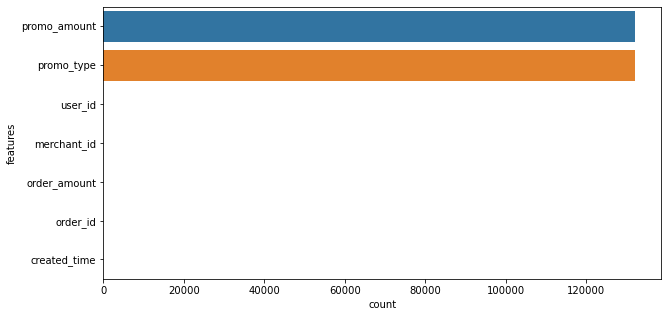

In [217]:
order_data = pd.read_csv('order_data.csv',delimiter=',')
#define columns has missing values
missing_columns = [col for col,pcg_missing in (order_data.isnull().sum()/len(order_data)).items() if pcg_missing > 0]
#how many missing values
features=[]
values=[]
for feats, value in order_data.isnull().sum().sort_values(ascending=False).items():
    features.append(feats)
    values.append(value)
dfcheck = pd.DataFrame(np.array([features,values])).T.rename(columns = {0:'features',1:'count'})
dfcheck['count'] = dfcheck['count'].astype('int64')
#visualize available values each features
plt.figure(figsize=(10,5))
sns.barplot(x='count',y='features',data=dfcheck)

In [218]:
order_data = pd.read_csv('order_data.csv',delimiter=',')
order_data = order_data.sort_values(['user_id','created_time'],ascending=True)
order_data['transaction_date'] = pd.to_datetime(order_data['created_time'],dayfirst=True)
order_data = order_data.reset_index().drop(['index','created_time'],axis=1)
order_data['trx_date'] = [order_data['transaction_date'][i].strftime("%Y-%m-%d") for i in range(len(df))]
order_data['trx_date'] = pd.to_datetime(order_data['trx_date'])
order_data['trx_month'] = [i.strftime('%Y-%m') for i in order_data['trx_date']]
order_data['hour_clock'] = [pd.to_datetime(num).strftime("%H") for num in order_data['transaction_date']]
order_data['promo_amount'] = order_data['promo_amount'].fillna(0)
order_data['promo_type'] = order_data['promo_type'].fillna('no promo')
order_data['net_amount'] = order_data['order_amount']-order_data['promo_amount']
order_data = order_data[['user_id','order_id','merchant_id','order_amount','promo_amount',
         'net_amount','promo_type','transaction_date','trx_date','trx_month','hour_clock']]
order_data

,user_id,order_id,merchant_id,order_amount,promo_amount,net_amount,promo_type,transaction_date,trx_date,trx_month,hour_clock
0,2690923546,100166549703841596,7455500373,4000,0.0,4000.0,no promo,2018-12-11 15:29:12,2018-12-11,2018-12,15
1,2690923546,100166542203863868,1496726697,4800,0.0,4800.0,no promo,2018-12-12 15:04:18,2018-12-12,2018-12,15
2,2690923546,100166547703863869,1496726697,4800,0.0,4800.0,no promo,2018-12-12 15:12:00,2018-12-12,2018-12,15
3,2690923546,100166548003863874,1496726697,4800,0.0,4800.0,no promo,2018-12-12 15:12:44,2018-12-12,2018-12,15
4,2690923546,100166543803863877,1496726697,4800,0.0,4800.0,no promo,2018-12-12 15:14:51,2018-12-12,2018-12,15
...,...,...,...,...,...,...,...,...,...,...,...
134123,6005079852,100166853304345088,1496726697,4800,0.0,4800.0,no promo,2019-01-08 14:10:04,2019-01-08,2019-01,14
134124,6005079852,100166851004554643,1496726697,4800,0.0,4800.0,no promo,2019-01-19 12:40:32,2019-01-19,2019-01,12
134125,6005079852,100166858904543755,1496726697,4800,0.0,4800.0,no promo,2019-01-19 12:41:16,2019-01-19,2019-01,12
134126,6005079852,100166853504677825,1496726697,7600,0.0,7600.0,no promo,2019-01-26 17:15:23,2019-01-26,2019-01,17


<AxesSubplot:xlabel='count', ylabel='features'>

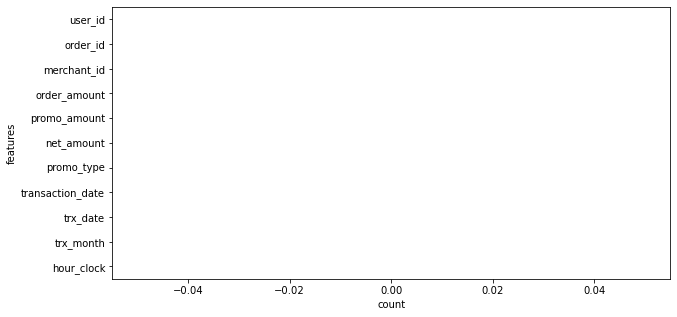

In [219]:
#define columns has missing values
missing_columns = [col for col,pcg_missing in (order_data.isnull().sum()/len(order_data)).items() if pcg_missing > 0]
#how many missing values
features=[]
values=[]
for feats, value in order_data.isnull().sum().sort_values(ascending=False).items():
    features.append(feats)
    values.append(value)
dfcheck = pd.DataFrame(np.array([features,values])).T.rename(columns = {0:'features',1:'count'})
dfcheck['count'] = dfcheck['count'].astype('int64')
#visualize available values each features
plt.figure(figsize=(10,5))
sns.barplot(x='count',y='features',data=dfcheck)

<AxesSubplot:xlabel='periods', ylabel='days'>

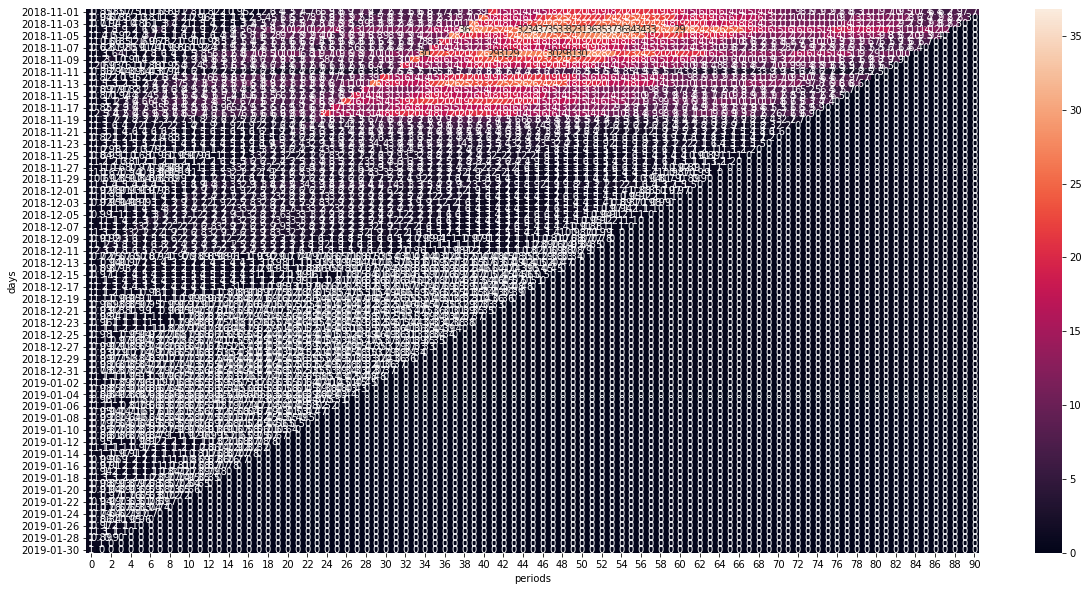

In [220]:
# cohort transaction analysis daily level
df_trx_cohort_clean = order_data[order_data['trx_date'].notna()]
df1 = df_trx_cohort_clean.groupby('trx_date',as_index=False)['user_id'].count()
df1.columns = ['acq_days','cohort_idx']
df1['acq_days'] = pd.to_datetime(df1['acq_days'])
df1['days'] = [i.strftime("%Y-%m-%d")for i in df1['acq_days']]
df1 = df1.groupby('days',as_index=False)['cohort_idx'].sum()
df1.columns =  ['last_trx_time_days','count_trx']
dfs = df1.copy()
dfesis = []
for i in range(len(dfs)):
    #real value
    dfm = dfs.copy().loc[i:]
    dfm['days'] = df1['last_trx_time_days'][i]
    dfm['periods'] = [i for i in range(len(dfm))]
    dfm['prob'] = [(dfm.count_trx[j]/dfm.count_trx[i]) for j in dfm.index]
    dfm['pcg'] = [100*(dfm.count_trx[j]/dfm.count_trx[i]) for j in dfm.index]
    dfesis.append(dfm)
dfesis = pd.concat(dfesis,axis=0).sort_values(by=['periods','last_trx_time_days'])
dfesis = dfesis.reset_index().drop('index',axis=1)
dfpivot_trx = dfesis.pivot(index='days',columns='periods',values='count_trx').fillna(0)
dfpivot_prob = dfesis.pivot(index='days',columns='periods',values='prob').fillna(0)
dfpivot_pcg = dfesis.pivot(index='days',columns='periods',values='pcg').fillna(0)
with pd.ExcelWriter('new_pivot_trx.xlsx') as writer1:
    dfpivot_trx.to_excel(writer1, sheet_name = 'df_trx', index = True)
    dfpivot_prob.to_excel(writer1, sheet_name = 'df_prob', index = True)
    dfpivot_pcg.to_excel(writer1, sheet_name = 'df_pcg', index = True)
plt.figure(figsize=(20,10))
sns.heatmap(dfpivot_prob,annot=True)

<AxesSubplot:xlabel='periods', ylabel='days'>

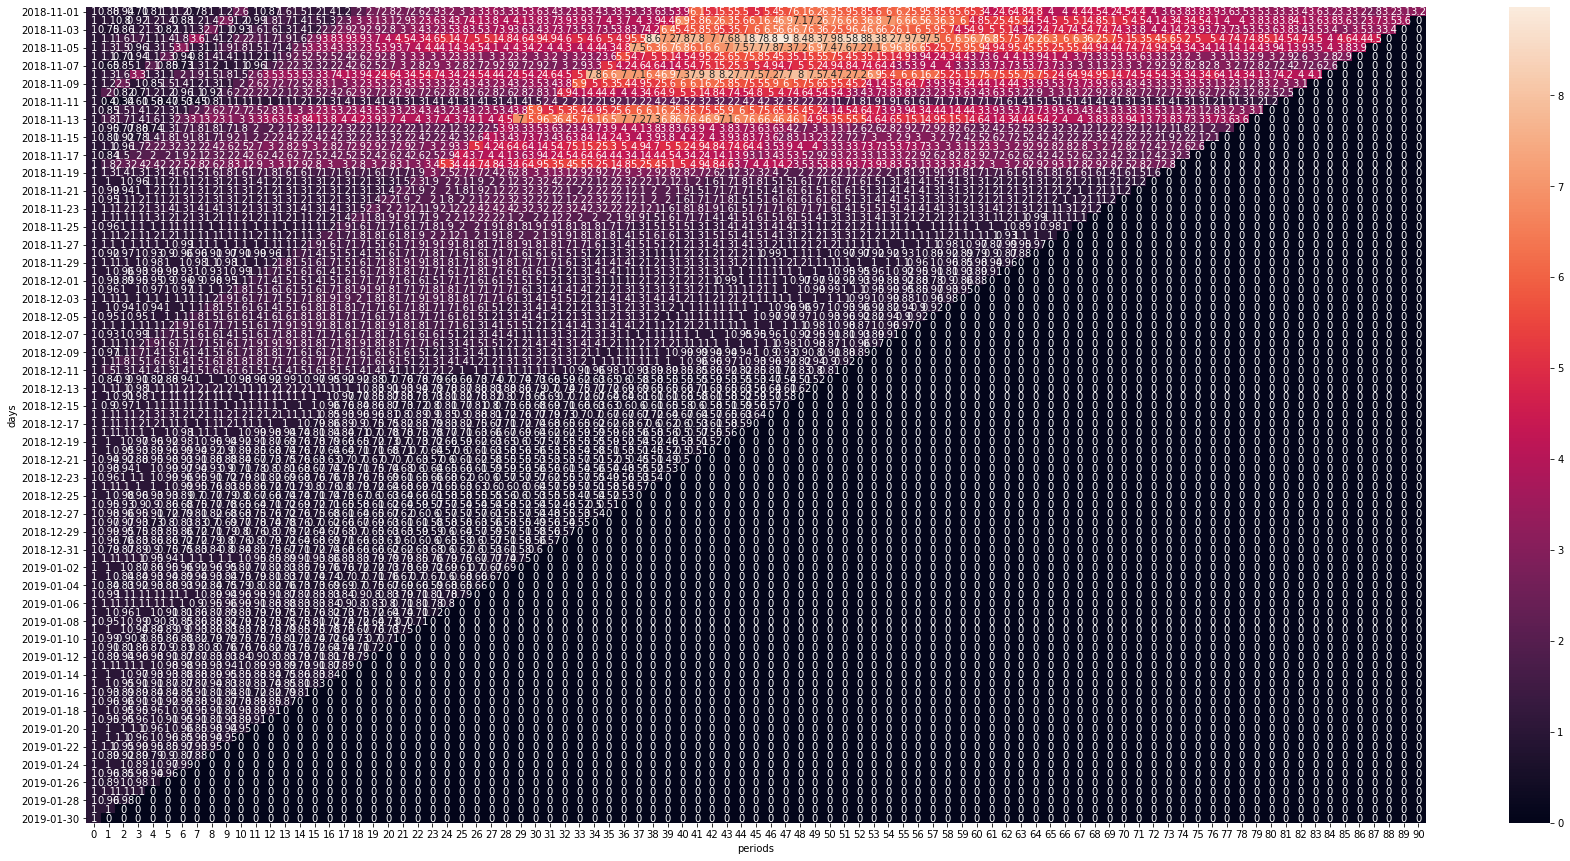

In [221]:
# cohort active users analysis daily level
df_trx_cohort_clean = order_data[order_data['trx_date'].notna()]
df1 = df_trx_cohort_clean.groupby('trx_date',as_index=False)['user_id'].nunique()
df1.columns = ['acq_days','cohort_idx']
df1['acq_days'] = pd.to_datetime(df1['acq_days'])
df1['days'] = [i.strftime("%Y-%m-%d")for i in df1['acq_days']]
df1 = df1.groupby('days',as_index=False)['cohort_idx'].sum()
df1.columns =  ['last_trx_time_days','count_trx']
dfs = df1.copy()
dfesis = []
for i in range(len(dfs)):
    #real value
    dfm = dfs.copy().loc[i:]
    dfm['days'] = df1['last_trx_time_days'][i]
    dfm['periods'] = [i for i in range(len(dfm))]
    dfm['prob'] = [(dfm.count_trx[j]/dfm.count_trx[i]) for j in dfm.index]
    dfm['pcg'] = [100*(dfm.count_trx[j]/dfm.count_trx[i]) for j in dfm.index]
    dfesis.append(dfm)
dfesis = pd.concat(dfesis,axis=0).sort_values(by=['periods','last_trx_time_days'])
dfesis = dfesis.reset_index().drop('index',axis=1)
dfpivot_trx = dfesis.pivot(index='days',columns='periods',values='count_trx').fillna(0)
dfpivot_prob = dfesis.pivot(index='days',columns='periods',values='prob').fillna(0)
dfpivot_pcg = dfesis.pivot(index='days',columns='periods',values='pcg').fillna(0)
with pd.ExcelWriter('new_pivot_active_users.xlsx') as writer1:
    dfpivot_trx.to_excel(writer1, sheet_name = 'df_trx', index = True)
    dfpivot_prob.to_excel(writer1, sheet_name = 'df_prob', index = True)
    dfpivot_pcg.to_excel(writer1, sheet_name = 'df_pcg', index = True)
plt.figure(figsize=(30,15))
sns.heatmap(dfpivot_prob,annot=True)

# Feature Engineering

In [222]:
#average of daily transactions each users
df_daily_trx = order_data.copy()
df_daily_trx = df_daily_trx[['user_id','trx_date','order_id']].groupby(['user_id','trx_date'],as_index=False).count().rename(columns={'order_id':'num_trx'})
df_daily_trx = df_daily_trx[['user_id','num_trx']].groupby(['user_id'],as_index=False).median().rename(columns={'num_trx':'daily_avg_trx'})
display(df_daily_trx.head())
#average of monthly transactions each users
df_monthly_trx = order_data.copy()
df_monthly_trx = df_monthly_trx[['user_id','trx_month','order_id']].groupby(['user_id','trx_month'],as_index=False).count().rename(columns={'order_id':'num_trx'})
df_monthly_trx = df_monthly_trx[['user_id','num_trx']].groupby(['user_id'],as_index=False).median().rename(columns={'num_trx':'monthly_avg_trx'})
display(df_monthly_trx.head())

,user_id,daily_avg_trx
0,2690923546,8.0
1,2706381515,2.0
2,2762014923,4.0
3,2826429982,3.0
4,2872739820,1.0


,user_id,monthly_avg_trx
0,2690923546,53.5
1,2706381515,17.0
2,2762014923,54.0
3,2826429982,46.0
4,2872739820,1.0


In [223]:
#average of daily order amount each users
df_daily_ord_amt = order_data.copy()
df_daily_ord_amt = df_daily_ord_amt[['user_id','trx_date','order_amount']].groupby(['user_id','trx_date'],as_index=False)['order_amount'].sum().rename(columns={'order_amount':'sum_amount'})
df_daily_ord_amt = df_daily_ord_amt[['user_id','sum_amount']].groupby(['user_id'],as_index=False).median().rename(columns={'sum_amount':'daily_avg_ord_amt'})
display(df_daily_ord_amt.head())
#average of monthly order amount each users
df_monthly_ord_amt = order_data.copy()
df_monthly_ord_amt = df_monthly_ord_amt[['user_id','trx_month','order_amount']].groupby(['user_id','trx_month'],as_index=False)['order_amount'].sum().rename(columns={'order_amount':'sum_amount'})
df_monthly_ord_amt = df_monthly_ord_amt[['user_id','sum_amount']].groupby(['user_id'],as_index=False).median().rename(columns={'sum_amount':'monthly_avg_ord_amt'})
display(df_monthly_ord_amt.head())

,user_id,daily_avg_ord_amt
0,2690923546,40000.0
1,2706381515,38000.0
2,2762014923,29600.0
3,2826429982,19200.0
4,2872739820,31500.0


,user_id,monthly_avg_ord_amt
0,2690923546,270760.0
1,2706381515,434440.0
2,2762014923,752405.0
3,2826429982,381934.0
4,2872739820,31500.0


In [224]:
#average of daily promo amount each users
df_daily_prm_amt = order_data.copy()
df_daily_prm_amt = df_daily_prm_amt[['user_id','trx_date','promo_amount']].groupby(['user_id','trx_date'],as_index=False)['promo_amount'].sum().rename(columns={'promo_amount':'sum_amount'})
df_daily_prm_amt = df_daily_prm_amt[['user_id','sum_amount']].groupby(['user_id'],as_index=False).mean().rename(columns={'sum_amount':'daily_avg_prm_amt'})
display(df_daily_prm_amt.head())
#average of monthly promo amount each users
df_monthly_prm_amt = order_data.copy()
df_monthly_prm_amt = df_monthly_prm_amt[['user_id','trx_month','promo_amount']].groupby(['user_id','trx_month'],as_index=False)['promo_amount'].sum().rename(columns={'promo_amount':'sum_amount'})
df_monthly_prm_amt = df_monthly_prm_amt[['user_id','sum_amount']].groupby(['user_id'],as_index=False).mean().rename(columns={'sum_amount':'monthly_avg_prm_amt'})
display(df_monthly_prm_amt.head())

,user_id,daily_avg_prm_amt
0,2690923546,0.000000
1,2706381515,3934.615385
2,2762014923,1380.416667
3,2826429982,680.000000
4,2872739820,0.000000


,user_id,monthly_avg_prm_amt
0,2690923546,0.000000
1,2706381515,34100.000000
2,2762014923,22086.666667
3,2826429982,11333.333333
4,2872739820,0.000000


In [225]:
#average of daily net amount each users
df_daily_net_amt = order_data.copy()
df_daily_net_amt = df_daily_net_amt[['user_id','trx_date','net_amount']].groupby(['user_id','trx_date'],as_index=False)['net_amount'].sum().rename(columns={'net_amount':'sum_amount'})
df_daily_net_amt = df_daily_net_amt[['user_id','sum_amount']].groupby(['user_id'],as_index=False).median().rename(columns={'sum_amount':'daily_avg_net_amt'})
display(df_daily_net_amt.head())
#average of monthly net amount each users
df_monthly_net_amt = order_data.copy()
df_monthly_net_amt = df_monthly_net_amt[['user_id','trx_month','net_amount']].groupby(['user_id','trx_month'],as_index=False)['net_amount'].sum().rename(columns={'net_amount':'sum_amount'})
df_monthly_net_amt = df_monthly_net_amt[['user_id','sum_amount']].groupby(['user_id'],as_index=False).median().rename(columns={'sum_amount':'monthly_avg_net_amt'})
display(df_monthly_net_amt.head())

,user_id,daily_avg_net_amt
0,2690923546,40000.0
1,2706381515,35420.0
2,2762014923,29600.0
3,2826429982,18520.0
4,2872739820,31500.0


,user_id,monthly_avg_net_amt
0,2690923546,270760.0
1,2706381515,418040.0
2,2762014923,742405.0
3,2826429982,381934.0
4,2872739820,31500.0


In [272]:
df_diff_trx = order_data.copy()[['user_id','transaction_date']]
df_diff_trx['LastEvent'] = df_diff_trx.sort_values(by=['transaction_date'], ascending=True).groupby(['user_id'])['transaction_date'].shift(-1)
df_diff_trx = df_diff_trx.dropna()
df_diff_trx = df_diff_trx.sort_values(by=['user_id','transaction_date'])
train_flag.loc[:,'LastEvent'] = df_diff_trx.loc[:,'LastEvent'].fillna(df_diff_trx.loc[:,'transaction_date'])
df_diff_trx['diff_seconds'] = (df_diff_trx['LastEvent']-df_diff_trx['transaction_date'])/np.timedelta64(1, 's')
df_diff_trx = df_diff_trx.drop(['transaction_date','LastEvent'],axis=1)
df_diff_trx = df_diff_trx[['user_id','diff_seconds']].groupby(['user_id'],as_index=False).median().rename(columns={'diff_seconds':'diff_avg_seconds'})
df_diff_trx

,user_id,diff_avg_seconds
0,2690923546,61.0
1,2706381515,82.5
2,2762014923,49.0
3,2826429982,50.0
4,2872739820,3442697.0
...,...,...
1110,5998574074,36.0
1111,5998691661,57.0
1112,5999410847,19086.5
1113,6000460969,77.0


In [273]:
train_cat = order_data.copy()[['user_id','promo_type']]
user_id = []
nopromo_trx = []
coupon_trx = []
spinwheel_trx = []
for num in list(train_cat['user_id'].unique()):
    train = train_cat[train_cat['user_id']==num] 
    user_id.append(num)
    nopromo_trx.append([val if 'no' in col else 0 for col,val in train['promo_type'].value_counts().items()][0])
    coupon_trx.append([val if 'SPIN' in col else 0 for col,val in train['promo_type'].value_counts().items()][0])
    spinwheel_trx.append([val if 'CO' in col else 0 for col,val in train['promo_type'].value_counts().items()][0])
dfcat_train = pd.concat([pd.Series(user_id,name='user_id'),
pd.Series(nopromo_trx,name='nopromo_trx'),
pd.Series(coupon_trx,name='coupon_trx'),
pd.Series(spinwheel_trx,name='spinwheel_trx')],axis=1)
dfcat_train

,user_id,nopromo_trx,coupon_trx,spinwheel_trx
0,2690923546,107,0,0
1,2706381515,87,0,0
2,2762014923,190,0,0
3,2826429982,206,0,0
4,2872739820,2,0,0
...,...,...,...,...
1160,5998574074,106,0,0
1161,5998691661,112,0,0
1162,5999410847,161,0,0
1163,6000460969,109,0,0


In [274]:
#average of daily net amount each users
df_mrcht_trx = order_data.copy()
df_mrcht_trx = df_mrcht_trx[['user_id','trx_month','merchant_id']].groupby(['user_id','trx_month'],as_index=False)['merchant_id'].nunique().rename(columns={'merchant_id':'sum_mrcht'})
df_mrcht_trx = df_mrcht_trx[['user_id','sum_mrcht']].groupby(['user_id'],as_index=False).median().rename(columns={'sum_mrcht':'monthly_sum_mrcht'})
display(df_mrcht_trx.head())

,user_id,monthly_sum_mrcht
0,2690923546,3.0
1,2706381515,7.0
2,2762014923,5.0
3,2826429982,4.0
4,2872739820,1.0


In [275]:
df_last_time = order_data.copy()
df_last_time = df_last_time[['user_id','trx_date']].groupby('user_id',as_index=False).max().rename(columns={'trx_date':'last_created_time'})
df_last_time

,user_id,last_created_time
0,2690923546,2019-01-24
1,2706381515,2019-01-30
2,2762014923,2019-01-30
3,2826429982,2019-01-30
4,2872739820,2018-12-29
...,...,...
1160,5998574074,2019-01-09
1161,5998691661,2019-01-14
1162,5999410847,2019-01-30
1163,6000460969,2019-01-28


In [277]:
#created data training by targeting using average delta time each transactions and flag churn if more than 20 days
df1 = pd.merge(df_mrcht_trx,df_daily_trx,how='left',on='user_id')
df2 = pd.merge(df1,df_monthly_trx,how='left',on='user_id')
df3 = pd.merge(df2,df_daily_ord_amt,how='left',on='user_id')
df4 = pd.merge(df3,df_monthly_ord_amt,how='left',on='user_id')
df5 = pd.merge(df4,df_daily_prm_amt,how='left',on='user_id')
df6 = pd.merge(df5,df_daily_net_amt,how='left',on='user_id')
df7 = pd.merge(df6,df_monthly_net_amt,how='left',on='user_id')
df8 = pd.merge(df7,dfcat_train,how='left',on='user_id')
df_predictor = pd.merge(df8,df_diff_trx,how='left',on='user_id')
df_predictor

,user_id,monthly_sum_mrcht,daily_avg_trx,monthly_avg_trx,daily_avg_ord_amt,monthly_avg_ord_amt,daily_avg_prm_amt,daily_avg_net_amt,monthly_avg_net_amt,nopromo_trx,coupon_trx,spinwheel_trx,diff_avg_seconds
0,2690923546,3.0,8.0,53.5,40000.0,270760.0,0.000000,40000.0,270760.0,107,0,0,61.0
1,2706381515,7.0,2.0,17.0,38000.0,434440.0,3934.615385,35420.0,418040.0,87,0,0,82.5
2,2762014923,5.0,4.0,54.0,29600.0,752405.0,1380.416667,29600.0,742405.0,190,0,0,49.0
3,2826429982,4.0,3.0,46.0,19200.0,381934.0,680.000000,18520.0,381934.0,206,0,0,50.0
4,2872739820,1.0,1.0,1.0,31500.0,31500.0,0.000000,31500.0,31500.0,2,0,0,3442697.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,5998574074,1.0,3.0,41.0,27570.0,356440.0,0.000000,27570.0,356440.0,106,0,0,36.0
1161,5998691661,2.0,2.0,41.0,18800.0,388400.0,0.000000,18800.0,388400.0,112,0,0,57.0
1162,5999410847,1.0,2.0,54.0,39280.0,957553.0,0.000000,39280.0,957553.0,161,0,0,19086.5
1163,6000460969,2.0,2.5,54.5,76000.0,997348.5,0.000000,76000.0,997348.5,109,0,0,77.0


In [320]:
#created data training with targeting last_created_time on order data minus last date on january 2019 which is 2019-01-31
# as the order data dates until end of january 31,i assume the current situations is similiar
df_training = pd.merge(df_last_time,data,how='inner',on='user_id')
df_training['target_days'] = [(datetime.datetime(2019, 1, 31)-i).days for i in df_training['last_created_time']]
df_training['flag_churn'] = np.where(df_training['target_days']>20,1,0)
df_training = df_training.drop(['last_created_time','last_trx_date','target_days'],axis=1)
display(df_training.head())
#created data testing with targeting last_trx_date on test_data minus 2019-02-28. Choosing February 28 as
#calculations because i assume if any customers that haven't transacted until 20 days and it is exactly on
#February 28 means this customers doesn't churn and started to churn if they dont continue transaction in the next days
# means 1 march as in the questions are looking for
df_testing = pd.merge(df_last_time,data,how='inner',on='user_id')
df_testing['target_days'] = [(datetime.datetime(2019, 2, 28)-i).days for i in df_testing['last_trx_date']]
df_testing['flag_churn'] = np.where(df_testing['target_days']>20,1,0)
df_testing = df_testing.drop(['last_created_time','last_trx_date','target_days'],axis=1)
display(df_testing.head())

,user_id,is_premium_user,flag_churn
0,2690923546,0,0
1,2706381515,1,0
2,2762014923,1,0
3,2826429982,1,0
4,2872739820,0,1


,user_id,is_premium_user,flag_churn
0,2690923546,0,0
1,2706381515,1,0
2,2762014923,1,0
3,2826429982,1,0
4,2872739820,0,1


In [366]:
#df training
dftrain = pd.merge(df_predictor,df_training,how='inner',on='user_id')
dftrain.head()

,user_id,monthly_sum_mrcht,daily_avg_trx,monthly_avg_trx,daily_avg_ord_amt,monthly_avg_ord_amt,daily_avg_prm_amt,daily_avg_net_amt,monthly_avg_net_amt,nopromo_trx,coupon_trx,spinwheel_trx,diff_avg_seconds,is_premium_user,flag_churn
0,2690923546,3.0,8.0,53.5,40000.0,270760.0,0.000000,40000.0,270760.0,107,0,0,61.0,0,0
1,2706381515,7.0,2.0,17.0,38000.0,434440.0,3934.615385,35420.0,418040.0,87,0,0,82.5,1,0
2,2762014923,5.0,4.0,54.0,29600.0,752405.0,1380.416667,29600.0,742405.0,190,0,0,49.0,1,0
3,2826429982,4.0,3.0,46.0,19200.0,381934.0,680.000000,18520.0,381934.0,206,0,0,50.0,1,0
4,2872739820,1.0,1.0,1.0,31500.0,31500.0,0.000000,31500.0,31500.0,2,0,0,3442697.0,0,1


In [367]:
#df training
dftest = pd.merge(df_predictor,df_testing,how='inner',on='user_id')
dftest.head()

,user_id,monthly_sum_mrcht,daily_avg_trx,monthly_avg_trx,daily_avg_ord_amt,monthly_avg_ord_amt,daily_avg_prm_amt,daily_avg_net_amt,monthly_avg_net_amt,nopromo_trx,coupon_trx,spinwheel_trx,diff_avg_seconds,is_premium_user,flag_churn
0,2690923546,3.0,8.0,53.5,40000.0,270760.0,0.000000,40000.0,270760.0,107,0,0,61.0,0,0
1,2706381515,7.0,2.0,17.0,38000.0,434440.0,3934.615385,35420.0,418040.0,87,0,0,82.5,1,0
2,2762014923,5.0,4.0,54.0,29600.0,752405.0,1380.416667,29600.0,742405.0,190,0,0,49.0,1,0
3,2826429982,4.0,3.0,46.0,19200.0,381934.0,680.000000,18520.0,381934.0,206,0,0,50.0,1,0
4,2872739820,1.0,1.0,1.0,31500.0,31500.0,0.000000,31500.0,31500.0,2,0,0,3442697.0,0,1


# Imputation missing value on data preparation

<AxesSubplot:xlabel='count', ylabel='features'>

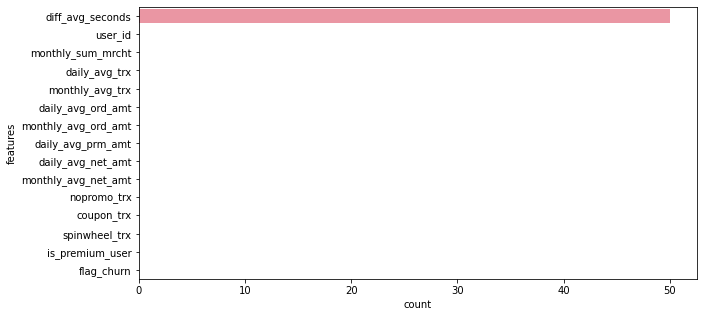

In [368]:
#define columns has missing values on train data
missing_columns = [col for col,pcg_missing in (dftrain.isnull().sum()/len(dftrain)).items() if pcg_missing > 0]
#how many missing values
features=[]
values=[]
for feats, value in dftrain.isnull().sum().sort_values(ascending=False).items():
    features.append(feats)
    values.append(value)
dfcheck = pd.DataFrame(np.array([features,values])).T.rename(columns = {0:'features',1:'count'})
dfcheck['count'] = dfcheck['count'].astype('int64')
#visualize available values each features
plt.figure(figsize=(10,5))
sns.barplot(x='count',y='features',data=dfcheck)

In [369]:
#find the imputations value for missing value based on premiur user
dftrain[['is_premium_user','diff_avg_seconds']].groupby('is_premium_user',as_index=False).median()
#imputation missing value on training data
dftrain.loc[(dftrain['diff_avg_seconds'].isnull()) & (dftrain['is_premium_user']==1),'diff_avg_seconds'] = 94.75
dftrain.loc[(dftrain['diff_avg_seconds'].isnull()) & (dftrain['is_premium_user']==0),'diff_avg_seconds'] = 127.50
#imputation missing value on testing data
dftest.loc[(dftest['diff_avg_seconds'].isnull()) & (dftest['is_premium_user']==1),'diff_avg_seconds'] = 94.75
dftest.loc[(dftest['diff_avg_seconds'].isnull()) & (dftest['is_premium_user']==0),'diff_avg_seconds'] = 127.50

<AxesSubplot:xlabel='count', ylabel='features'>

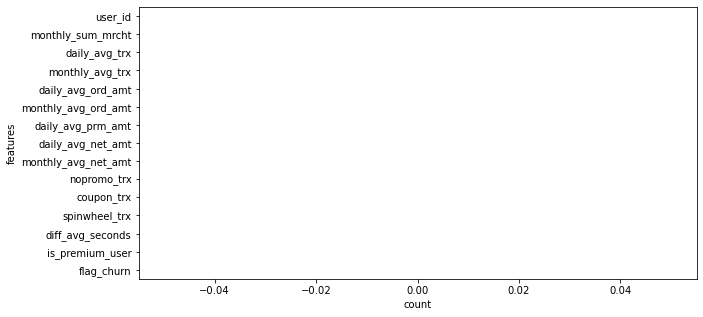

In [370]:
#check is still any missing values
missing_columns = [col for col,pcg_missing in (dftrain.isnull().sum()/len(dftrain)).items() if pcg_missing > 0]
#how many missing values
features=[]
values=[]
for feats, value in dftrain.isnull().sum().sort_values(ascending=False).items():
    features.append(feats)
    values.append(value)
dfcheck = pd.DataFrame(np.array([features,values])).T.rename(columns = {0:'features',1:'count'})
dfcheck['count'] = dfcheck['count'].astype('int64')
#visualize available values each features
plt.figure(figsize=(10,5))
sns.barplot(x='count',y='features',data=dfcheck)

# Feature Sleection

In [371]:
dfopt = dftrain.copy()
dfopt.head()

,user_id,monthly_sum_mrcht,daily_avg_trx,monthly_avg_trx,daily_avg_ord_amt,monthly_avg_ord_amt,daily_avg_prm_amt,daily_avg_net_amt,monthly_avg_net_amt,nopromo_trx,coupon_trx,spinwheel_trx,diff_avg_seconds,is_premium_user,flag_churn
0,2690923546,3.0,8.0,53.5,40000.0,270760.0,0.000000,40000.0,270760.0,107,0,0,61.0,0,0
1,2706381515,7.0,2.0,17.0,38000.0,434440.0,3934.615385,35420.0,418040.0,87,0,0,82.5,1,0
2,2762014923,5.0,4.0,54.0,29600.0,752405.0,1380.416667,29600.0,742405.0,190,0,0,49.0,1,0
3,2826429982,4.0,3.0,46.0,19200.0,381934.0,680.000000,18520.0,381934.0,206,0,0,50.0,1,0
4,2872739820,1.0,1.0,1.0,31500.0,31500.0,0.000000,31500.0,31500.0,2,0,0,3442697.0,0,1


Optimal Splits :  [1.25 1.75 2.75]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.25)",739,0.634335,431,308,0.416779,-0.358427,0.085706,0.010656
1,"[1.25, 1.75)",87,0.074678,56,31,0.356322,-0.103071,0.000807,0.000101
2,"[1.75, 2.75)",229,0.196567,184,45,0.196507,0.713838,0.086252,0.010558
3,"[2.75, inf)",110,0.094421,106,4,0.036364,2.58271,0.325713,0.032196
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1165,1.000000,777,388,0.333047,,0.498478,0.053511


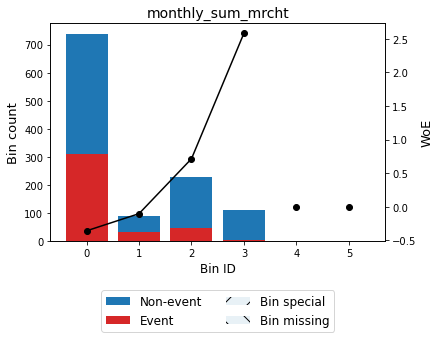

None

In [372]:
#monthly_sum_mrcht
optb = OptimalBinning(name='monthly_sum_mrcht', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['monthly_sum_mrcht'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

In [373]:
# 1) function to transform : monthly_sum_mrcht
def get_woe(x):
    y = None
    if x <= 1.25:
        y = 0
    elif (x <= 1.75) and (x > 1.25):
        y = 1
    elif (x <= 2.75) and (x > 1.75):
        y = 2
    else:
        y = 3
    return y
# transform
dftrain['monthly_sum_mrcht_bin'] = dftrain['monthly_sum_mrcht'].map(lambda x: get_woe(x))
dftest['monthly_sum_mrcht_bin'] = dftest['monthly_sum_mrcht'].map(lambda x: get_woe(x))

def get_woe(x):
    y = None
    if x <= 1.25:
        y = -0.358427*x
    elif (x <= 1.75) and (x > 1.25):
        y = -0.103071*x
    elif (x <= 2.75) and (x > 1.75):
        y = 0.713838*x
    else:
        y = 2.58271*x
    return y
# transform
dftrain['monthly_sum_mrcht_weighted'] = dftrain['monthly_sum_mrcht'].map(lambda x: get_woe(x))
dftest['monthly_sum_mrcht_weighted'] = dftest['monthly_sum_mrcht'].map(lambda x: get_woe(x))

Optimal Splits :  [ 1.75  2.25  3.75  4.25  5.75 10.75]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.75)",456,0.391416,206,250,0.548246,-0.88802,0.336744,0.040762
1,"[1.75, 2.25)",131,0.112446,105,26,0.198473,0.701429,0.047785,0.005854
2,"[2.25, 3.75)",125,0.107296,109,16,0.128000,1.224324,0.121264,0.014277
3,"[3.75, 4.25)",95,0.081545,80,15,0.157895,0.979541,0.062985,0.007573
4,"[4.25, 5.75)",92,0.078970,76,16,0.173913,0.86371,0.048864,0.005925
5,"[5.75, 10.75)",205,0.175966,161,44,0.214634,0.60278,0.056544,0.006963
6,"[10.75, inf)",61,0.052361,40,21,0.344262,-0.050078,0.000132,0.000017
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1165,1.000000,777,388,0.333047,,0.674318,0.081370


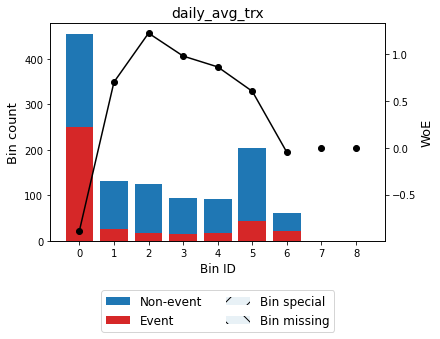

None

In [374]:
#daily_avg_trx
optb = OptimalBinning(name='daily_avg_trx', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['daily_avg_trx'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

In [375]:
# 2) function to transform : daily_avg_trx - keep
def get_woe(x):
    y = None
    if x <= 1.75:
        y = 0
    else:
        y = 1
    return y
# transform
dftrain['daily_avg_trx_bin'] = dftrain['daily_avg_trx'].map(lambda x: get_woe(x))
dftest['daily_avg_trx_bin'] = dftest['daily_avg_trx'].map(lambda x: get_woe(x))

def get_woe(x):
    y = None
    if x <= 1.75:
        y = -0.88801976*x
    else:
        y = 0.725700514*x
    return y

# transform
dftrain['daily_avg_trx_weighted'] = dftrain['daily_avg_trx'].map(lambda x: get_woe(x))
dftest['daily_avg_trx_weighted'] = dftest['daily_avg_trx'].map(lambda x: get_woe(x))

Optimal Splits :  [  1.75   2.75   3.75   5.75  11.25  63.25 107.5 ]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.75)",154,0.132189,37,117,0.759740,-1.845691,0.468671,0.051469
1,"[1.75, 2.75)",131,0.112446,51,80,0.610687,-1.144636,0.160877,0.019079
2,"[2.75, 3.75)",79,0.067811,36,43,0.544304,-0.872116,0.056245,0.006816
3,"[3.75, 5.75)",78,0.066953,38,40,0.512821,-0.745728,0.040409,0.004937
4,"[5.75, 11.25)",63,0.054077,49,14,0.222222,0.558328,0.015064,0.001859
5,"[11.25, 63.25)",347,0.297854,278,69,0.198847,0.69908,0.125800,0.015412
6,"[63.25, 107.50)",193,0.165665,170,23,0.119171,1.305869,0.208302,0.024332
7,"[107.50, inf)",120,0.103004,118,2,0.016667,3.383102,0.496340,0.043079
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


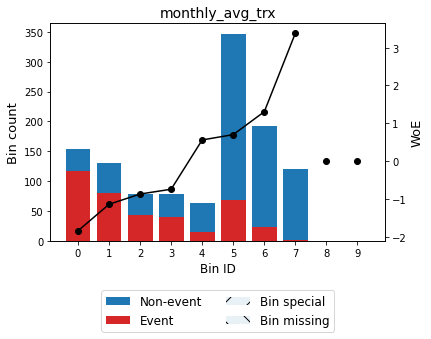

None

In [376]:
#monthly_avg_trx
optb = OptimalBinning(name='monthly_avg_trx', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['monthly_avg_trx'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

In [377]:
# 2) function to transform : monthly_avg_trx - keep
def get_woe(x):
    y = None
    if x <= 1.75:
        y = 0
    elif (x <= 2.75) and (x > 1.75):
        y = 1
    elif (x <= 3.75) and (x > 2.75):
        y = 2
    elif (x <= 5.75) and (x > 3.75):
        y = 3
    elif (x <= 11.25) and (x > 5.75):
        y = 4
    elif (x <= 63.25) and (x > 11.25):
        y = 5
    elif (x <= 107.5) and (x > 63.25):
        y = 6
    else:
        y = 7
    return y
# transform
dftrain['monthly_avg_trx_bin'] = dftrain['monthly_avg_trx'].map(lambda x: get_woe(x))
dftest['monthly_avg_trx_bin'] = dftest['monthly_avg_trx'].map(lambda x: get_woe(x))

def get_woe(x):
    y = None
    if x <= 1.75:
        y = -1.845691*x
    elif (x <= 2.75) and (x > 1.75):
        y = -1.144636*x
    elif (x <= 3.75) and (x > 2.75):
        y = -0.872116*x
    elif (x <= 5.75) and (x > 3.75):
        y = -0.745728*x
    elif (x <= 11.25) and (x > 5.75):
        y = 0.558328*x
    elif (x <= 63.25) and (x > 11.25):
        y = 0.69908*x
    elif (x <= 107.5) and (x > 63.25):
        y = 1.305869*x
    else:
        y = 3.383102*x
    return y

# transform
dftrain['monthly_avg_trx_weighted'] = dftrain['monthly_avg_trx'].map(lambda x: get_woe(x))
dftest['monthly_avg_trx_weighted'] = dftest['monthly_avg_trx'].map(lambda x: get_woe(x))

Optimal Splits :  [14170. 19002. 19870. 46375. 54200.]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 14170.00)",157,0.134764,88,69,0.439490,-0.451205,0.029138,0.003612
1,"[14170.00, 19002.00)",134,0.115021,87,47,0.350746,-0.078674,0.000721,0.000090
2,"[19002.00, 19870.00)",68,0.058369,62,6,0.088235,1.64094,0.105562,0.011889
3,"[19870.00, 46375.00)",613,0.526180,423,190,0.309951,0.105913,0.005795,0.000724
4,"[46375.00, 54200.00)",69,0.059227,47,22,0.318841,0.06467,0.000245,0.000031
5,"[54200.00, inf)",124,0.106438,70,54,0.435484,-0.434924,0.021348,0.002648
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1165,1.000000,777,388,0.333047,,0.162809,0.018993


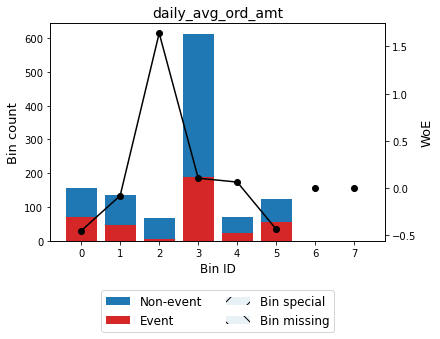

None

In [378]:
#daily_avg_ord_amt
optb = OptimalBinning(name='daily_avg_ord_amt', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['daily_avg_ord_amt'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

Optimal Splits :  [ 22300.  32380.  65080.  79500. 137636. 295740. 358668. 564076.]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 22300.00)",78,0.066953,15,63,0.807692,-2.12952,0.304662,0.032204
1,"[22300.00, 32380.00)",62,0.053219,16,46,0.741935,-1.750488,0.171486,0.019060
2,"[32380.00, 65080.00)",180,0.154506,79,101,0.561111,-0.940108,0.149135,0.017984
3,"[65080.00, 79500.00)",60,0.051502,34,26,0.433333,-0.426171,0.009909,0.001229
4,"[79500.00, 137636.00)",119,0.102146,71,48,0.403361,-0.302956,0.009796,0.001220
5,"[137636.00, 295740.00)",181,0.155365,131,50,0.276243,0.268739,0.010677,0.001331
6,"[295740.00, 358668.00)",83,0.071245,65,18,0.216867,0.589581,0.021970,0.002707
7,"[358668.00, 564076.00)",221,0.189700,197,24,0.108597,1.410715,0.270411,0.031251
8,"[564076.00, inf)",181,0.155365,169,12,0.066298,1.950557,0.363926,0.039422
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


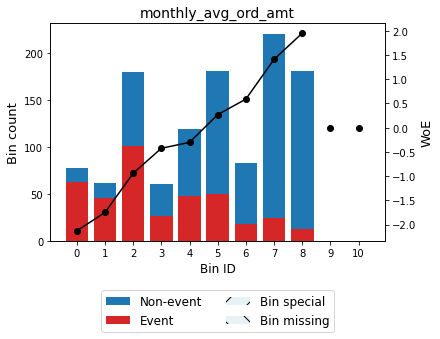

None

In [379]:
#monthly_avg_ord_amt
optb = OptimalBinning(name='monthly_avg_ord_amt', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['monthly_avg_ord_amt'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

In [380]:
# 7) function to transform : monthly_avg_ord_amt - keep
def get_woe(x):
    y = None
    if x <= 22300:
        y = 0
    elif (x <= 32380) and (x > 22300):
        y = 1
    elif (x <= 65080) and (x > 32380):
        y = 2
    elif (x <= 79500) and (x > 65080):
        y = 3
    elif (x <= 137636) and (x > 79500):
        y = 4
    elif (x <= 295740) and (x > 137636):
        y = 5
    elif (x <= 358668) and (x > 295740):
        y = 6
    elif (x <= 22300) and (x > 358668):
        y = 7
    else:
        y = 8
    return y
# transform
dftrain['monthly_avg_ord_amt_bin'] = dftrain['monthly_avg_ord_amt'].map(lambda x: get_woe(x))
dftest['monthly_avg_ord_amt_bin'] = dftest['monthly_avg_ord_amt'].map(lambda x: get_woe(x))

def get_woe(x):
    y = None
    if x <= 22300:
        y = -2.12952*x
    elif (x <= 32380) and (x > 22300):
        y = -1.750488*x
    elif (x <= 65080) and (x > 32380):
        y = -0.940108*x
    elif (x <= 79500) and (x > 65080):
        y = -0.426171*x
    elif (x <= 137636) and (x > 79500):
        y = -0.302956*x
    elif (x <= 295740) and (x > 137636):
        y = 0.268739*x
    elif (x <= 358668) and (x > 295740):
        y = 0.589581*x
    elif (x <= 22300) and (x > 358668):
        y = 1.410715*x
    else:
        y = 1.950557*x
    return y
# transform
dftrain['monthly_avg_ord_amt_weighted'] = dftrain['monthly_avg_ord_amt'].map(lambda x: get_woe(x))
dftest['monthly_avg_ord_amt_weighted'] = dftest['monthly_avg_ord_amt'].map(lambda x: get_woe(x))

Optimal Splits :  [  15.38461494  327.95700073  918.06451416 2462.5       ]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 15.38)",810,0.695279,484,326,0.402469,-0.299247,0.065026,0.008098
1,"[15.38, 327.96)",64,0.054936,63,1,0.015625,3.4487,0.270736,0.023241
2,"[327.96, 918.06)",92,0.078970,81,11,0.119565,1.302119,0.098826,0.011548
3,"[918.06, 2462.50)",120,0.103004,104,16,0.133333,1.177367,0.109037,0.012893
4,"[2462.50, inf)",79,0.067811,45,34,0.430380,-0.414133,0.012305,0.001527
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1165,1.000000,777,388,0.333047,,0.555931,0.057308


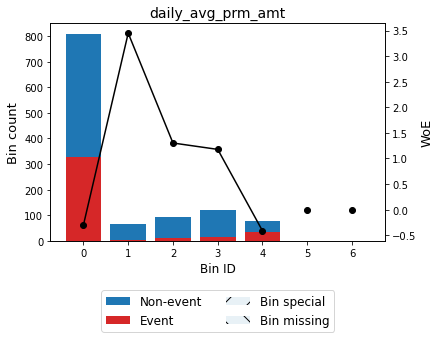

None

In [381]:
#daily_avg_prm_amt
optb = OptimalBinning(name='daily_avg_prm_amt', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['daily_avg_prm_amt'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

In [382]:
# 2) function to transform : daily_avg_prm_amt - keep
def get_woe(x):
    y = None
    if x <= 15.38:
        y = 0
    else:
        y = 1
    return y
# transform
dftrain['daily_avg_prm_amt_bin'] = dftrain['daily_avg_prm_amt'].map(lambda x: get_woe(x))
dftest['daily_avg_prm_amt_bin'] = dftest['daily_avg_prm_amt'].map(lambda x: get_woe(x))

def get_woe(x):
    y = None
    if x <= 15.38:
        y = -0.299247485*x
    else:
        y = 0.858603213*x
    return y
# transform
dftrain['daily_avg_prm_amt_weighted'] = dftrain['daily_avg_prm_amt'].map(lambda x: get_woe(x))
dftest['daily_avg_prm_amt_weighted'] = dftest['daily_avg_prm_amt'].map(lambda x: get_woe(x))

Optimal Splits :  [14205. 18460. 19870. 24001. 54200.]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 14205.00)",178,0.152790,98,80,0.449438,-0.491494,0.039349,0.004870
1,"[14205.00, 18460.00)",133,0.114163,88,45,0.338346,-0.023761,0.000065,0.000008
2,"[18460.00, 19870.00)",71,0.060944,62,9,0.126761,1.235475,0.069926,0.008224
3,"[19870.00, 24001.00)",156,0.133906,110,46,0.294872,0.177404,0.004083,0.000510
4,"[24001.00, 54200.00)",507,0.435193,350,157,0.309665,0.107252,0.004913,0.000614
5,"[54200.00, inf)",120,0.103004,69,51,0.425000,-0.392154,0.016722,0.002077
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1165,1.000000,777,388,0.333047,,0.135057,0.016302


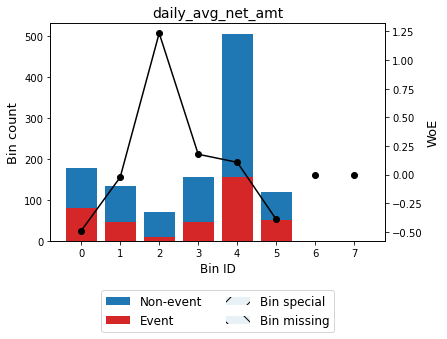

None

In [383]:
#daily_avg_net_amt
optb = OptimalBinning(name='daily_avg_net_amt', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['daily_avg_net_amt'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

Optimal Splits :  [ 22300.   32380.   41710.   60600.   89900.  143178.5 311347.5 359650.
 631718.  889904. ]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 22300.00)",92,0.078970,18,74,0.804348,-2.108128,0.353229,0.037450
1,"[22300.00, 32380.00)",62,0.053219,16,46,0.741935,-1.750488,0.171486,0.019060
2,"[32380.00, 41710.00)",64,0.054936,26,38,0.593750,-1.073925,0.069242,0.008262
3,"[41710.00, 60600.00)",95,0.081545,46,49,0.515789,-0.757614,0.050826,0.006206
4,"[60600.00, 89900.00)",110,0.094421,62,48,0.436364,-0.438502,0.019258,0.002388
5,"[89900.00, 143178.50)",89,0.076395,56,33,0.370787,-0.165591,0.002149,0.000268
6,"[143178.50, 311347.50)",202,0.173391,149,53,0.262376,0.339219,0.018713,0.002328
7,"[311347.50, 359650.00)",59,0.050644,48,11,0.186441,0.778871,0.026034,0.003174
8,"[359650.00, 631718.00)",251,0.215451,224,27,0.107570,1.421374,0.310855,0.035884
9,"[631718.00, 889904.00)",70,0.060086,65,5,0.071429,1.870514,0.132373,0.014491


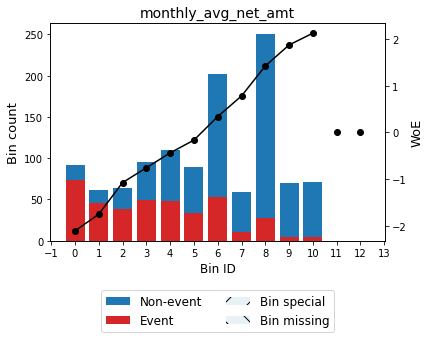

None

In [384]:
#monthly_avg_net_amt
optb = OptimalBinning(name='monthly_avg_net_amt', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['monthly_avg_net_amt'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

In [385]:
# 9) function to transform : monthly_avg_net_amt - keep
def get_woe(x):
    y = None
    if x <= 22300:
        y = 0
    elif (x <= 32380) and (x > 22300):
        y = 1
    elif (x <= 41710) and (x > 32380):
        y = 2
    elif (x <= 60600) and (x > 41710):
        y = 3
    elif (x <= 89900) and (x > 60600):
        y = 4
    elif (x <= 143178.5) and (x > 89900):
        y = 5
    elif (x <= 311347.5) and (x > 143178.5):
        y = 6
    elif (x <= 359650) and (x > 311347.5):
        y = 7
    elif (x <= 631718) and (x > 359650):
        y = 8
    elif (x <= 889904) and (x > 631718):
        y = 9
    else:
        y = 10
    return y
# transform
dftrain['monthly_avg_net_amt_bin'] = dftrain['monthly_avg_net_amt'].map(lambda x: get_woe(x))
dftest['monthly_avg_net_amt_bin'] = dftest['monthly_avg_net_amt'].map(lambda x: get_woe(x))

def get_woe(x):
    y = None
    if x <= 22300:
        y = -2.108128*x
    elif (x <= 32380) and (x > 22300):
        y = -1.750488*x
    elif (x <= 41710) and (x > 32380):
        y = -1.073925*x
    elif (x <= 60600) and (x > 41710):
        y = -0.757614*x
    elif (x <= 89900) and (x > 60600):
        y = -0.438502*x
    elif (x <= 143178.5) and (x > 89900):
        y = -0.165591*x
    elif (x <= 311347.5) and (x > 143178.5):
        y = 0.339219*x
    elif (x <= 359650) and (x > 311347.5):
        y = 0.778871*x
    elif (x <= 631718) and (x > 359650):
        y = 1.421374*x
    elif (x <= 889904) and (x > 631718):
        y = 1.870514*x
    else:
        y = 2.123963*x
    return y
# transform
dftrain['monthly_avg_net_amt_weighted'] = dftrain['monthly_avg_net_amt'].map(lambda x: get_woe(x))
dftest['monthly_avg_net_amt_weighted'] = dftest['monthly_avg_net_amt'].map(lambda x: get_woe(x))

Optimal Splits :  [  1.5   2.5   3.5   6.5  11.5 110.5 128.5 200.5]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",71,0.060944,4,67,0.943662,-3.512833,0.588513,0.049977
1,"[1.50, 2.50)",74,0.063519,13,61,0.824324,-2.24036,0.314738,0.032748
2,"[2.50, 3.50)",63,0.054077,13,50,0.793651,-2.041509,0.228924,0.024495
3,"[3.50, 6.50)",94,0.080687,43,51,0.542553,-0.865061,0.065833,0.007982
4,"[6.50, 11.50)",109,0.093562,65,44,0.403670,-0.304237,0.009050,0.001127
5,"[11.50, 110.50)",225,0.193133,143,82,0.364444,-0.13831,0.003776,0.000472
6,"[110.50, 128.50)",107,0.091845,91,16,0.149533,1.043836,0.079206,0.009474
7,"[128.50, 200.50)",215,0.184549,201,14,0.065116,1.969813,0.438490,0.047377
8,"[200.50, inf)",207,0.177682,204,3,0.014493,3.525073,0.898246,0.076122
9,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


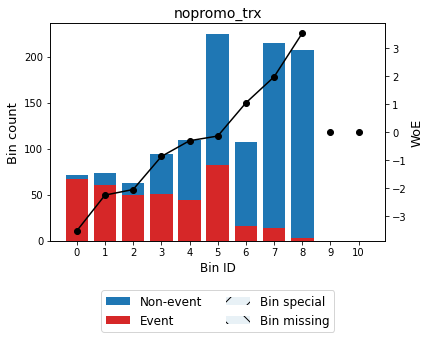

None

In [386]:
#nopromo_trx
optb = OptimalBinning(name='nopromo_trx', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['nopromo_trx'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

In [387]:
# 7) function to transform : nopromo_trx - keep
def get_woe(x):
    y = None
    if x <= 1.5:
        y = 0
    elif (x <= 2.5) and (x > 1.5):
        y = 1
    elif (x <= 3.5) and (x > 2.5):
        y = 2
    elif (x <= 6.5) and (x > 3.5):
        y = 3
    elif (x <= 11.5) and (x > 6.5):
        y = 4
    elif (x <= 110.5) and (x > 11.5):
        y = 5
    elif (x <= 128.5) and (x > 110.5):
        y = 6
    elif (x <= 200.5) and (x > 128.5):
        y = 7
    else:
        y = 8
    return y

# transform
dftrain['nopromo_trx_bin'] = dftrain['nopromo_trx'].map(lambda x: get_woe(x))
dftest['nopromo_trx_bin'] = dftest['nopromo_trx'].map(lambda x: get_woe(x))

def get_woe(x):
    y = None
    if x <= 1.5:
        y = -3.512833*x
    elif (x <= 2.5) and (x > 1.5):
        y = -2.24036*x
    elif (x <= 3.5) and (x > 2.5):
        y = -2.041509*x
    elif (x <= 6.5) and (x > 3.5):
        y = -0.865061*x
    elif (x <= 11.5) and (x > 6.5):
        y = -0.304237*x
    elif (x <= 110.5) and (x > 11.5):
        y = -0.13831*x
    elif (x <= 128.5) and (x > 110.5):
        y = 1.043836*x
    elif (x <= 200.5) and (x > 128.5):
        y = 1.969813*x
    else:
        y = 3.525073*x
    return y
# transform
dftrain['nopromo_trx_weighted'] = dftrain['nopromo_trx'].map(lambda x: get_woe(x))
dftest['nopromo_trx_weighted'] = dftest['nopromo_trx'].map(lambda x: get_woe(x))

Optimal Splits :  []


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",1165,1.0,777,388,0.333047,-0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,1165,1.0,777,388,0.333047,,0.0,0.0


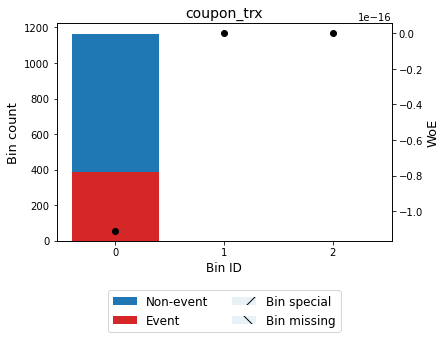

None

In [388]:
#coupon_trx
optb = OptimalBinning(name='coupon_trx', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['coupon_trx'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

Optimal Splits :  []


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",1165,1.0,777,388,0.333047,-0.0,0.0,0.0
1,Special,0,0.0,0,0,0.000000,0.0,0.0,0.0
2,Missing,0,0.0,0,0,0.000000,0.0,0.0,0.0
Totals,,1165,1.0,777,388,0.333047,,0.0,0.0


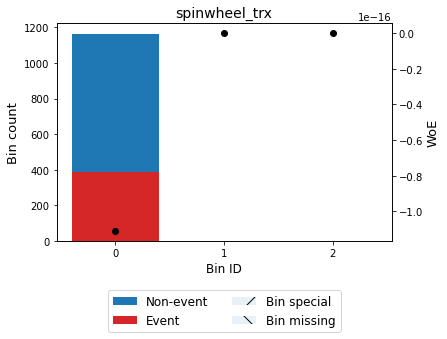

None

In [389]:
#spinwheel_trx
optb = OptimalBinning(name='spinwheel_trx', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['spinwheel_trx'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

Optimal Splits :  [2.52500000e+01 4.02500000e+01 6.02500000e+01 9.46250000e+01
 9.09682500e+04 1.10205275e+06]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 25.25)",98,0.084120,69,29,0.295918,0.172376,0.002424,0.000303
1,"[25.25, 40.25)",216,0.185408,172,44,0.203704,0.66887,0.072213,0.008862
2,"[40.25, 60.25)",140,0.120172,117,23,0.164286,0.932245,0.085115,0.010270
3,"[60.25, 94.62)",96,0.082403,88,8,0.083333,1.70346,0.157804,0.017641
4,"[94.62, 90968.25)",289,0.248069,186,103,0.356401,-0.103417,0.002697,0.000337
5,"[90968.25, 1102052.75)",230,0.197425,114,116,0.504348,-0.711827,0.108376,0.013268
6,"[1102052.75, inf)",96,0.082403,31,65,0.677083,-1.434835,0.183126,0.021109
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1165,1.000000,777,388,0.333047,,0.611755,0.071790


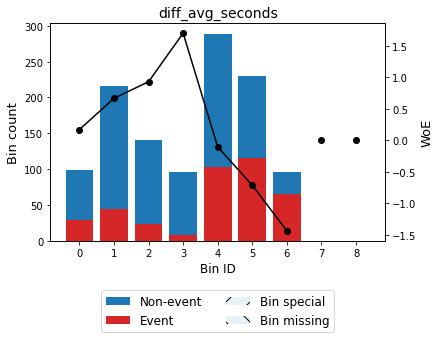

None

In [390]:
#diff_avg_seconds
optb = OptimalBinning(name='diff_avg_seconds', dtype="numerical", solver="cp")
data = dfopt.copy()
x = data['diff_avg_seconds'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

In [391]:
# 7) function to transform : diff_avg_seconds - keep
def get_woe(x):
    y = None
    if x <= 94.62:
        y = 0
    elif (x <= 90968.25) and (x > 94.62):
        y = 1
    elif (x <= 1102052.75) and (x > 90968.25):
        y = 2
    else:
        y = 3
    return y

# transform
dftrain['diff_avg_seconds_bin'] = dftrain['diff_avg_seconds'].map(lambda x: get_woe(x))
dftest['diff_avg_seconds_bin'] = dftest['diff_avg_seconds'].map(lambda x: get_woe(x))

def get_woe(x):
    y = None
    if x <= 94.62:
        y = 0.761493042*x
    elif (x <= 90968.25) and (x > 94.62):
        y = -0.103417325*x
    elif (x <= 1102052.75) and (x > 90968.25):
        y = -0.711826753*x
    else:
        y = -1.434835076*x
    return y
# transform
dftrain['diff_avg_seconds_weighted'] = dftrain['diff_avg_seconds'].map(lambda x: get_woe(x))
dftest['diff_avg_seconds_weighted'] = dftest['diff_avg_seconds'].map(lambda x: get_woe(x))

Optimal Splits :  [array([1], dtype=int64), array([0], dtype=int64)]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[1],815,0.699571,567,248,0.304294,0.132496,0.011998,0.001499
1,[0],350,0.300429,210,140,0.400000,-0.28897,0.026168,0.003260
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1165,1.000000,777,388,0.333047,,0.038166,0.004758


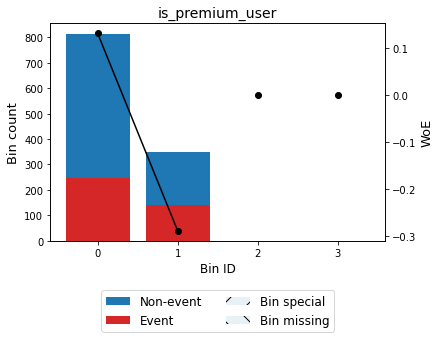

None

In [392]:
#is_premium_user
optb = OptimalBinning(name='is_premium_user', dtype="categorical", solver="cp")
data = dfopt.copy()
x = data['is_premium_user'].values
y = data['flag_churn']
optb.fit(x, y)
result = optb.splits
print("Optimal Splits : ", result)
display(optb.binning_table.build())
display(optb.binning_table.plot(metric="woe"))

In [394]:
# #final dataset
drop_columns=['daily_avg_ord_amt','daily_avg_net_amt','coupon_trx','spinwheel_trx']
dftrain = dftrain.drop(drop_columns,axis=1)
dftest = dftest.drop(drop_columns,axis=1)
dftrain.head()

,user_id,monthly_sum_mrcht,daily_avg_trx,monthly_avg_trx,monthly_avg_ord_amt,daily_avg_prm_amt,monthly_avg_net_amt,nopromo_trx,diff_avg_seconds,is_premium_user,flag_churn,monthly_sum_mrcht_bin,monthly_sum_mrcht_weighted,daily_avg_trx_bin,daily_avg_trx_weighted,monthly_avg_trx_bin,monthly_avg_trx_weighted,monthly_avg_ord_amt_bin,monthly_avg_ord_amt_weighted,daily_avg_prm_amt_bin,daily_avg_prm_amt_weighted,monthly_avg_net_amt_bin,monthly_avg_net_amt_weighted,nopromo_trx_bin,nopromo_trx_weighted,diff_avg_seconds_bin,diff_avg_seconds_weighted
0,2690923546,3.0,8.0,53.5,270760.0,0.000000,270760.0,107,61.0,0,0,3,7.748130,1,5.805604,5,37.400780,5,7.276377e+04,0,-0.000000,6,9.184694e+04,5,-14.799170,0,4.645108e+01
1,2706381515,7.0,2.0,17.0,434440.0,3934.615385,418040.0,87,82.5,1,0,3,18.078970,1,1.451401,5,11.884360,8,8.474000e+05,1,3378.273411,8,5.941912e+05,5,-12.032970,0,6.282318e+01
2,2762014923,5.0,4.0,54.0,752405.0,1380.416667,742405.0,190,49.0,1,0,3,12.913550,1,2.902802,5,37.750320,8,1.467609e+06,1,1185.230185,9,1.388679e+06,7,374.264470,0,3.731316e+01
3,2826429982,4.0,3.0,46.0,381934.0,680.000000,381934.0,206,50.0,1,0,3,10.330840,1,2.177102,5,32.157680,8,7.449840e+05,1,583.850185,8,5.428711e+05,8,726.165038,0,3.807465e+01
4,2872739820,1.0,1.0,1.0,31500.0,0.000000,31500.0,2,3442697.0,0,1,0,-0.358427,0,-0.888020,0,-1.845691,1,-5.514037e+04,0,-0.000000,1,-5.514037e+04,1,-4.480720,3,-4.939702e+06


# Initial Modelling - Logit Analysis

In [395]:
dfinit_train = dftrain.copy()
dfinit_test = dftest.copy()
dfinit_train = dfinit_train.rename(columns={'flag_churn':'Y'})
dfinit_test = dfinit_test.rename(columns={'flag_churn':'Y'})
for col in dfinit_train.columns:
    dfinit_train[col]=dfinit_train[col].astype('float64')
    dfinit_test[col]=dfinit_test[col].astype('float64')
dfinit_train.head()

,user_id,monthly_sum_mrcht,daily_avg_trx,monthly_avg_trx,monthly_avg_ord_amt,daily_avg_prm_amt,monthly_avg_net_amt,nopromo_trx,diff_avg_seconds,is_premium_user,Y,monthly_sum_mrcht_bin,monthly_sum_mrcht_weighted,daily_avg_trx_bin,daily_avg_trx_weighted,monthly_avg_trx_bin,monthly_avg_trx_weighted,monthly_avg_ord_amt_bin,monthly_avg_ord_amt_weighted,daily_avg_prm_amt_bin,daily_avg_prm_amt_weighted,monthly_avg_net_amt_bin,monthly_avg_net_amt_weighted,nopromo_trx_bin,nopromo_trx_weighted,diff_avg_seconds_bin,diff_avg_seconds_weighted
0,2.690924e+09,3.0,8.0,53.5,270760.0,0.000000,270760.0,107.0,61.0,0.0,0.0,3.0,7.748130,1.0,5.805604,5.0,37.400780,5.0,7.276377e+04,0.0,-0.000000,6.0,9.184694e+04,5.0,-14.799170,0.0,4.645108e+01
1,2.706382e+09,7.0,2.0,17.0,434440.0,3934.615385,418040.0,87.0,82.5,1.0,0.0,3.0,18.078970,1.0,1.451401,5.0,11.884360,8.0,8.474000e+05,1.0,3378.273411,8.0,5.941912e+05,5.0,-12.032970,0.0,6.282318e+01
2,2.762015e+09,5.0,4.0,54.0,752405.0,1380.416667,742405.0,190.0,49.0,1.0,0.0,3.0,12.913550,1.0,2.902802,5.0,37.750320,8.0,1.467609e+06,1.0,1185.230185,9.0,1.388679e+06,7.0,374.264470,0.0,3.731316e+01
3,2.826430e+09,4.0,3.0,46.0,381934.0,680.000000,381934.0,206.0,50.0,1.0,0.0,3.0,10.330840,1.0,2.177102,5.0,32.157680,8.0,7.449840e+05,1.0,583.850185,8.0,5.428711e+05,8.0,726.165038,0.0,3.807465e+01
4,2.872740e+09,1.0,1.0,1.0,31500.0,0.000000,31500.0,2.0,3442697.0,0.0,1.0,0.0,-0.358427,0.0,-0.888020,0.0,-1.845691,1.0,-5.514037e+04,0.0,-0.000000,1.0,-5.514037e+04,1.0,-4.480720,3.0,-4.939702e+06


In [399]:
# first try
y = dfinit_train['Y']
X = dfinit_train[['is_premium_user']+[col for col in dfinit_train.columns if '_weighted' in col]+[col for col in dfinit_train.columns if '_bin' in col]]
model_credit_scoring = sm.Logit(y, X)
result_scoring = model_credit_scoring.fit()
result_scoring.summary()

Optimization terminated successfully.
         Current function value: 0.358457
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1165
Model:                          Logit   Df Residuals:                     1148
Method:                           MLE   Df Model:                           16
Date:                Sun, 10 Apr 2022   Pseudo R-squ.:                  0.4367
Time:                        13:15:06   Log-Likelihood:                -417.60
converged:                       True   LL-Null:                       -741.31
Covariance Type:            nonrobust   LLR p-value:                1.971e-127
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
is_premium_user                  0.4149      0.183      2.273      0.023       0.057       0.773
monthly_sum_mrcht_weighted      -0.3594      0.113     -3.190      0.001      -0.580      -0.139
daily_avg_trx_weighted           0.3913      0.063      6.174      0.000       0.267       0.516
monthly_avg_trx_weighted         0.0059      0.004      1.601      0.109      -0.001       0.013
monthly_avg_ord_amt_weighted -1.701e-06   1.64e-06     -1.039      0.299   -4.91e-06    1.51e-06
daily_avg_prm_amt_weighted     5.08e-05   4.31e-05      1.179      0.238   -3.36e-05       0.000
monthly_avg_net_amt_weighted  1.486e-06   1.58e-06      0.940      0.347   -1.61e-06    4.59e-06
nopromo_trx_weighted            -0.0062      0.001     -4.557      0.000      -0.009      -0.004
diff_avg_seconds_weighted     5.553e-07   1.03e-07      5.385      0.000    3.53e-07    7.57e-07
monthly_sum_mrcht_bin            0.2387      0.185      1.290      0.197      -0.124       0.601
daily_avg_trx_bin                1.1772      0.402      2.926      0.003       0.389       1.966
monthly_avg_trx_bin              0.1081      0.112      0.965      0.335      -0.111       0.328
monthly_avg_ord_amt_bin          0.2871      0.245      1.173      0.241      -0.193       0.767
daily_avg_prm_amt_bin           -1.2939      0.284     -4.562      0.000      -1.850      -0.738
monthly_avg_net_amt_bin         -0.1631      0.201     -0.810      0.418      -0.558       0.232
nopromo_trx_bin                 -0.7897      0.100     -7.913      0.000      -0.985      -0.594
diff_avg_seconds_bin             1.2816      0.146      8.782      0.000       0.996       1.568
================================================================================================
"""

In [472]:
# second Try
remove_columns = ['monthly_avg_net_amt_bin','monthly_avg_net_amt_weighted','monthly_avg_ord_amt_weighted',
                 'monthly_avg_ord_amt_bin','monthly_sum_mrcht_bin','monthly_avg_trx_weighted',
                  'daily_avg_prm_amt_weighted']
X = dfinit_train[['is_premium_user']+[col for col in dfinit_train.columns if '_weighted' in col]+[col for col in dfinit_train.columns if '_bin' in col]]
X = X.drop(remove_columns,axis=1)
model_credit_scoring = sm.Logit(y, X)
result_scoring = model_credit_scoring.fit()
result_scoring.summary()

Optimization terminated successfully.
         Current function value: 0.363392
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 1165
Model:                          Logit   Df Residuals:                     1155
Method:                           MLE   Df Model:                            9
Date:                Sun, 10 Apr 2022   Pseudo R-squ.:                  0.4289
Time:                        13:58:42   Log-Likelihood:                -423.35
converged:                       True   LL-Null:                       -741.31
Covariance Type:            nonrobust   LLR p-value:                4.082e-131
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
is_premium_user                0.4123      0.180      2.294      0.022       0.060       0.765
monthly_sum_mrcht_weighted    -0.2718      0.068     -3.984      0.000      -0.406      -0.138
daily_avg_trx_weighted         0.4260      0.060      7.158      0.000       0.309       0.543
nopromo_trx_weighted          -0.0048      0.001     -4.857      0.000      -0.007      -0.003
diff_avg_seconds_weighted    5.59e-07   1.04e-07      5.397      0.000    3.56e-07    7.62e-07
daily_avg_trx_bin              1.1770      0.394      2.990      0.003       0.405       1.949
monthly_avg_trx_bin            0.2449      0.096      2.560      0.010       0.057       0.432
daily_avg_prm_amt_bin         -0.9492      0.242     -3.928      0.000      -1.423      -0.476
nopromo_trx_bin               -0.8299      0.092     -9.008      0.000      -1.010      -0.649
diff_avg_seconds_bin           1.3803      0.142      9.698      0.000       1.101       1.659
==============================================================================================
"""

In [473]:
#split train and test data before doing some missing value analysis
Xtrain = X
ytrain = y
Xtest = dfinit_test[X.columns]
ytest = dfinit_test['Y']
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=42)
dftrain = pd.concat([Xtrain, ytrain],axis=1)
dftest = pd.concat([Xtest, ytest],axis=1)

In [474]:
display(dftrain.head())
display(dftest.head())

,is_premium_user,monthly_sum_mrcht_weighted,daily_avg_trx_weighted,nopromo_trx_weighted,diff_avg_seconds_weighted,daily_avg_trx_bin,monthly_avg_trx_bin,daily_avg_prm_amt_bin,nopromo_trx_bin,diff_avg_seconds_bin,Y
0,0.0,7.748130,5.805604,-14.799170,4.645108e+01,1.0,5.0,0.0,5.0,0.0,0.0
1,1.0,18.078970,1.451401,-12.032970,6.282318e+01,1.0,5.0,1.0,5.0,0.0,0.0
2,1.0,12.913550,2.902802,374.264470,3.731316e+01,1.0,5.0,1.0,7.0,0.0,0.0
3,1.0,10.330840,2.177102,726.165038,3.807465e+01,1.0,5.0,1.0,8.0,0.0,0.0
4,0.0,-0.358427,-0.888020,-4.480720,-4.939702e+06,0.0,0.0,0.0,1.0,3.0,1.0


,is_premium_user,monthly_sum_mrcht_weighted,daily_avg_trx_weighted,nopromo_trx_weighted,diff_avg_seconds_weighted,daily_avg_trx_bin,monthly_avg_trx_bin,daily_avg_prm_amt_bin,nopromo_trx_bin,diff_avg_seconds_bin,Y
0,0.0,7.748130,5.805604,-14.799170,4.645108e+01,1.0,5.0,0.0,5.0,0.0,0.0
1,1.0,18.078970,1.451401,-12.032970,6.282318e+01,1.0,5.0,1.0,5.0,0.0,0.0
2,1.0,12.913550,2.902802,374.264470,3.731316e+01,1.0,5.0,1.0,7.0,0.0,0.0
3,1.0,10.330840,2.177102,726.165038,3.807465e+01,1.0,5.0,1.0,8.0,0.0,0.0
4,0.0,-0.358427,-0.888020,-4.480720,-4.939702e+06,0.0,0.0,0.0,1.0,3.0,1.0


In [475]:
def plot_auc(ax, y_train=[], y_train_pred=[], y_test=[], y_test_pred=[]):
    
    if ((len(y_train)>0)&(len(y_train_pred)>0)):
        fpr_train, tpr_train, _ = roc_curve(y_train,y_train_pred)
        roc_auc_train = metrics.auc(fpr_train, tpr_train)
        ax.plot(fpr_train, tpr_train)
    if ((len(y_test)>0)&(len(y_test_pred)>0)):        
        fpr_test, tpr_test, _ = roc_curve(y_test,y_test_pred)
        roc_auc_test = metrics.auc(fpr_test, tpr_test)
        ax.plot(fpr_test, tpr_test)        
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    train_text = None
    test_text = None
    if ((len(y_train)>0)&(len(y_train_pred)>0)):
        train_text = 'TRAIN auc = {:.2f}'.format(roc_auc_train)
    if ((len(y_test)>0)&(len(y_test_pred)>0)):
        test_text = 'TEST  auc = {:.2f}'.format(roc_auc_test)
    leg = []
    if ((len(y_train)>0)&(len(y_train_pred)>0)):
        leg.append(train_text)
    if ((len(y_test)>0)&(len(y_test_pred)>0)):
        leg.append(test_text)
    ax.legend(leg)    

In [476]:
#check imbalance or not?
print("""Berdasarkan hasil di bawah dapat dilihat bahwa data memiliki proporsi yang imbalance (tidak seimbang)""")
ytrain.value_counts(True)

Berdasarkan hasil di bawah dapat dilihat bahwa data memiliki proporsi yang imbalance (tidak seimbang)


0.0    0.666953
1.0    0.333047
Name: Y, dtype: float64

In [511]:
model = []
NLL_Train_score = []
NLL_Test_score = []
AUC_Train_score = []
AUC_Test_score = []
AUC_delta_score = []
times = []

In [512]:
#Build model with Decision Trees
import time
start_time = time.time()
def dectree_fit(x_train, y_train, scoring = 'accuracy'):
    dectree = DecisionTreeClassifier(random_state=123)
    hyperparam = {'min_samples_split': [3, 5, 7, 9, 13, 17, 21, 27, 33, 41, 50, 60, 80, 100],
                  'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.75],
                  'max_depth': [2, 4, 6, 8]                 }
    random_dectree = RandomizedSearchCV(dectree, 
                                        param_distributions= hyperparam, 
                                        cv = 3, n_iter = 5, 
                                        scoring = scoring, n_jobs=-1, random_state = 123)    
    random_dectree.fit(x_train, y_train)    
    print ("Best Accuracy", random_dectree.best_score_)
    print ("Best Param", random_dectree.best_params_)
    return random_dectree
best_dectree = dectree_fit(Xtrain,ytrain)
dectree = DecisionTreeClassifier(random_state=123,
                                  min_samples_split= best_dectree.best_params_.get('min_samples_split'),
                                  max_features = best_dectree.best_params_.get('max_features'),
                                  max_depth = best_dectree.best_params_.get('max_depth'))
dectree.fit(Xtrain,ytrain)
roc_train=roc_auc_score(ytrain, dectree.predict_proba(Xtrain)[:,1])
print('NLL Train Score = ',log_loss(ytrain, np.round(dectree.predict_proba(Xtrain),2).tolist()))
roc_test=roc_auc_score(ytest, dectree.predict_proba(Xtest)[:,1])
print('NLL Test Score = ',log_loss(ytest, np.round(dectree.predict_proba(Xtest),2).tolist()))
# input result
model.append('Decision Tree')
NLL_Train_score.append(log_loss(ytrain, np.round(dectree.predict_proba(Xtrain),2).tolist()))
NLL_Test_score.append(log_loss(ytest, np.round(dectree.predict_proba(Xtest),2).tolist()))
AUC_Train_score.append(roc_train)
AUC_Test_score.append(roc_test)
AUC_delta_score.append(abs(roc_train-roc_test))
times.append(time.time() - start_time)

Best Accuracy 0.8016921527575332
Best Param {'min_samples_split': 21, 'max_features': 'log2', 'max_depth': 6}
NLL Train Score =  0.30927176376931675
NLL Test Score =  1.263707823647054


<Figure size 720x360 with 0 Axes>

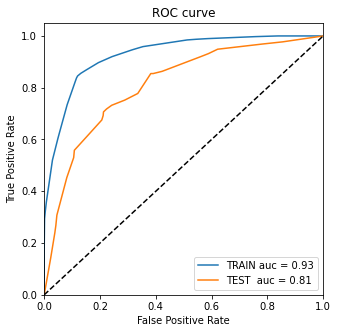

<Figure size 720x360 with 0 Axes>

In [513]:
#plot auc
fig,ax = plt.subplots(1)
fig.set_size_inches(5,5)
plot_auc(ax, 
         y_train=ytrain, 
         y_train_pred=dectree.predict_proba(Xtrain)[:,1], 
         y_test=ytest, 
         y_test_pred=dectree.predict_proba(Xtest)[:,1]
        )
plt.figure(figsize=(10,5))

<AxesSubplot:>

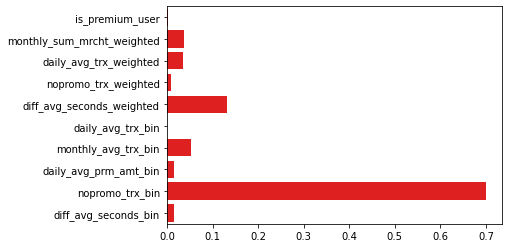

In [514]:
sns.barplot(list(dectree.feature_importances_),list(Xtrain.columns),color='Red')

In [515]:
#Build model with  Random Forest
import time
start_time = time.time()
def rf_fit(x_train, y_train, scoring = 'accuracy'):
    random_forest = RandomForestClassifier(random_state=123)
    hyperparam = {'min_samples_split': [3, 5, 7, 9, 13, 17, 21, 27, 33, 41, 50, 60, 80, 100],
                  'max_features': ['sqrt', 'log2', 0.25, 0.5, 0.75], 
                  'n_estimators': [100, 200, 300, 500, 750, 1000]}    
    random_rf = RandomizedSearchCV(random_forest, 
                                             param_distributions = hyperparam,
                                             cv = 5, 
                                             n_iter = 10, 
                                             scoring = scoring, 
                                             n_jobs=-1, 
                                             random_state = 123)   
    random_rf.fit(x_train, y_train)
    print("Best Accuracy", random_rf.best_score_)
    print("Best Param", random_rf.best_params_)
    return random_rf
best_rf = rf_fit(Xtrain,ytrain)
randomforest = RandomForestClassifier(random_state=123, n_jobs = -1,
                                   min_samples_split = best_rf.best_params_.get('min_samples_split'),
                                   max_features = best_rf.best_params_.get('max_features'),
                                   n_estimators = best_rf.best_params_.get('n_estimators'))
randomforest.fit(Xtrain,ytrain)
roc_train=roc_auc_score(ytrain, randomforest.predict_proba(Xtrain)[:,1])
print('NLL Train Score = ',log_loss(ytrain, np.round(randomforest.predict_proba(Xtrain),2).tolist()))
roc_test=roc_auc_score(ytest, randomforest.predict_proba(Xtest)[:,1])
print('NLL Test Score = ',log_loss(ytest, np.round(randomforest.predict_proba(Xtest),2).tolist()))
# input result
model.append('randomforest')
NLL_Train_score.append(log_loss(ytrain, np.round(randomforest.predict_proba(Xtrain),2).tolist()))
NLL_Test_score.append(log_loss(ytest, np.round(randomforest.predict_proba(Xtest),2).tolist()))
AUC_Train_score.append(roc_train)
AUC_Test_score.append(roc_test)
AUC_delta_score.append(abs(roc_train-roc_test))
times.append(time.time() - start_time)

Best Accuracy nan
Best Param {'n_estimators': 1000, 'min_samples_split': 5, 'max_features': 'sqrt'}
NLL Train Score =  0.1501738847675152
NLL Test Score =  0.9206972425665022


<Figure size 720x360 with 0 Axes>

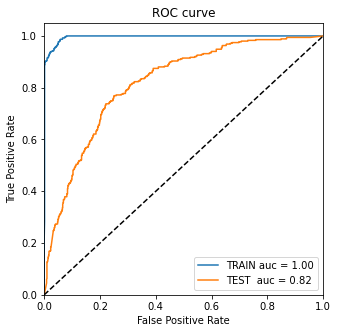

<Figure size 720x360 with 0 Axes>

In [516]:
#plot auc
fig,ax = plt.subplots(1)
fig.set_size_inches(5,5)
plot_auc(ax, 
         y_train=ytrain, 
         y_train_pred=randomforest.predict_proba(Xtrain)[:,1], 
         y_test=ytest, 
         y_test_pred=randomforest.predict_proba(Xtest)[:,1]
        )
plt.figure(figsize=(10,5))

<AxesSubplot:>

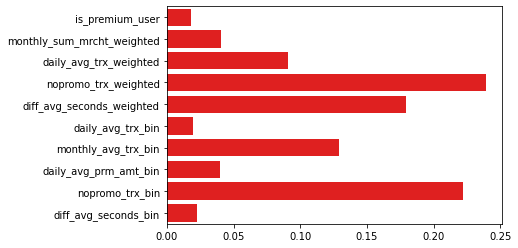

In [517]:
sns.barplot(list(randomforest.feature_importances_),list(Xtrain.columns),color='Red')

In [518]:
#Build model with  Bagging
import time
start_time = time.time()
def bagging_fit(x_train, y_train, scoring = 'accuracy'):
    dectree = DecisionTreeClassifier(random_state=123)
    
    bagging = BaggingClassifier(base_estimator = dectree, 
                                random_state=123)
    
    hyperparam = {'base_estimator__min_samples_split': [3, 5, 7, 9, 13, 17, 21, 27, 33, 41, 50, 60, 80, 100],
                  'base_estimator__max_depth': [2, 4, 6, 8],
                  'n_estimators': [100, 200, 300, 500, 750, 1000]}
    random_bagging = RandomizedSearchCV(bagging, 
                                        param_distributions = hyperparam, 
                                        cv = 5, 
                                        n_iter = 10, 
                                        scoring = scoring,
                                        n_jobs = -1, 
                                        random_state = 123)
    
    random_bagging.fit(x_train, y_train)
    
    print("Best Accuracy", random_bagging.best_score_)
    print("Best Param", random_bagging.best_params_)
    return random_bagging
best_bagging = bagging_fit(Xtrain,ytrain)
dectree_bagging = DecisionTreeClassifier(min_samples_split = best_bagging.best_params_.get('base_estimator__min_samples_split'),
                                         max_depth = best_bagging.best_params_.get('base_estimator__max_depth'),
                                         random_state=123)
bagging = BaggingClassifier(base_estimator = dectree_bagging, 
                            n_estimators = best_bagging.best_params_.get('n_estimators'),
                            random_state=123, n_jobs=-1)

bagging.fit(Xtrain,ytrain)
roc_train=roc_auc_score(ytrain, bagging.predict_proba(Xtrain)[:,1])
print('NLL Train Score = ',log_loss(ytrain, np.round(bagging.predict_proba(Xtrain),2).tolist()))
roc_test=roc_auc_score(ytest, bagging.predict_proba(Xtest)[:,1])
print('NLL Test Score = ',log_loss(ytest, np.round(bagging.predict_proba(Xtest),2).tolist()))
# input result
model.append('bagging')
NLL_Train_score.append(log_loss(ytrain, np.round(bagging.predict_proba(Xtrain),2).tolist()))
NLL_Test_score.append(log_loss(ytest, np.round(bagging.predict_proba(Xtest),2).tolist()))
AUC_Train_score.append(roc_train)
AUC_Test_score.append(roc_test)
AUC_delta_score.append(abs(roc_train-roc_test))
times.append(time.time() - start_time)

Best Accuracy 0.8334763948497855
Best Param {'n_estimators': 100, 'base_estimator__min_samples_split': 17, 'base_estimator__max_depth': 8}
NLL Train Score =  0.2294155482365164
NLL Test Score =  0.8272617812779747


<Figure size 720x360 with 0 Axes>

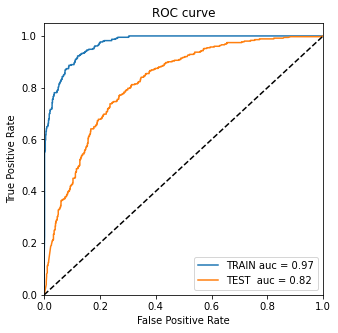

<Figure size 720x360 with 0 Axes>

In [519]:
#plot auc
fig,ax = plt.subplots(1)
fig.set_size_inches(5,5)
plot_auc(ax, 
         y_train=ytrain, 
         y_train_pred=bagging.predict_proba(Xtrain)[:,1], 
         y_test=ytest, 
         y_test_pred=bagging.predict_proba(Xtest)[:,1]
        )
plt.figure(figsize=(10,5))

In [520]:
#Build model with  Adaboost
import time
start_time = time.time()
def adaboost_fit(x_train, y_train, scoring = 'accuracy'):
    dectree = DecisionTreeClassifier(random_state=123)    
    adaboost = AdaBoostClassifier(base_estimator = dectree,random_state=123)    
    hyperparam = {'base_estimator__min_samples_split': [3, 5, 7, 9, 
                                                       13, 17, 21, 27, 
                                                       33, 41, 50, 60, 
                                                       80, 100],
                  'base_estimator__max_features': ['sqrt', 'log2', 
                                                   0.25, 0.5, 0.75],
                  'learning_rate': [0.01, 0.015, 0.02, 
                                    0.05, 0.08, 0.1],
                  'n_estimators': [100, 200, 300, 
                                   500, 750, 1000]}    
    random_adaboost = RandomizedSearchCV(adaboost, 
                                         param_distributions = hyperparam, 
                                         cv = 5, 
                                         n_iter = 10, 
                                         scoring = scoring, 
                                         n_jobs=-1, 
                                         random_state = 123)    
    random_adaboost.fit(x_train, y_train)    
    print ("Best Accuracy", random_adaboost.best_score_)
    print ("Best Param", random_adaboost.best_params_)
    return random_adaboost
best_adaboost = adaboost_fit(Xtrain,ytrain)
dectree_boost = DecisionTreeClassifier(min_samples_split = best_adaboost.best_params_.get('base_estimator__min_samples_split'),
                                      max_features = best_adaboost.best_params_.get('base_estimator__max_features'),
                                      random_state=123)
adaboost = AdaBoostClassifier(base_estimator = dectree_boost, 
                             n_estimators = best_adaboost.best_params_.get('n_estimators'),
                             learning_rate = best_adaboost.best_params_.get('learning_rate'),
                             random_state=123)

adaboost.fit(Xtrain,ytrain)
roc_train=roc_auc_score(ytrain, adaboost.predict_proba(Xtrain)[:,1])
print('NLL Train Score = ',log_loss(ytrain, np.round(adaboost.predict_proba(Xtrain),2).tolist()))
roc_test=roc_auc_score(ytest, adaboost.predict_proba(Xtest)[:,1])
print('NLL Test Score = ',log_loss(ytest, np.round(adaboost.predict_proba(Xtest),2).tolist()))
# input result
model.append('adaboost')
NLL_Train_score.append(log_loss(ytrain, np.round(adaboost.predict_proba(Xtrain),2).tolist()))
NLL_Test_score.append(log_loss(ytest, np.round(adaboost.predict_proba(Xtest),2).tolist()))
AUC_Train_score.append(roc_train)
AUC_Test_score.append(roc_test)
AUC_delta_score.append(abs(roc_train-roc_test))
times.append(time.time() - start_time)

Best Accuracy 0.8197424892703863
Best Param {'n_estimators': 100, 'learning_rate': 0.015, 'base_estimator__min_samples_split': 9, 'base_estimator__max_features': 0.25}
NLL Train Score =  0.005611228885553838
NLL Test Score =  8.065374715395011


<Figure size 720x360 with 0 Axes>

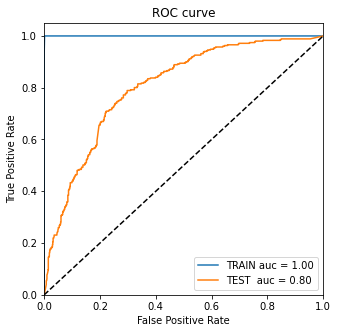

<Figure size 720x360 with 0 Axes>

In [521]:
#plot auc
fig,ax = plt.subplots(1)
fig.set_size_inches(5,5)
plot_auc(ax, 
         y_train=ytrain, 
         y_train_pred=adaboost.predict_proba(Xtrain)[:,1], 
         y_test=ytest, 
         y_test_pred=adaboost.predict_proba(Xtest)[:,1]
        )
plt.figure(figsize=(10,5))

<AxesSubplot:>

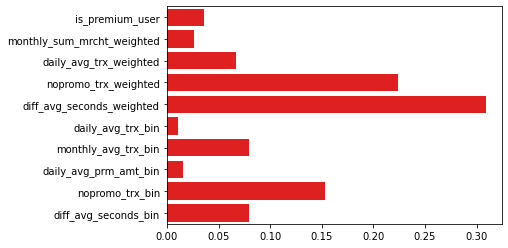

In [522]:
sns.barplot(list(adaboost.feature_importances_),list(Xtrain.columns),color='Red')

Best Accuracy 0.7227467811158798
Best Param {'C': 0.33}
NLL Train Score =  0.5545881661240565
NLL Test Score =  0.794116354752583


<Figure size 720x360 with 0 Axes>

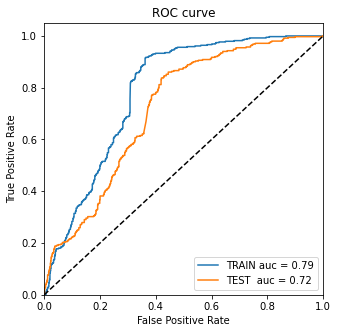

<Figure size 720x360 with 0 Axes>

In [523]:
# model logistik
def logreg_fit(x_train, y_train):
    logreg = LogisticRegression()
    hyperparam = {'C': [1000, 333.33, 100, 33.33, 10, 3.33, 10, 3.33, 1, 0.33, 0.1, 0.033, 0.01, 0.0033, 0.001, 0.00033, 0.0001]}
    random_logreg = RandomizedSearchCV(logreg, param_distributions = hyperparam, cv = 5,
                                    n_iter = 10, n_jobs=2, random_state = 123)
    
    random_logreg.fit(x_train, y_train)    
    print ("Best Accuracy", random_logreg.best_score_)
    print ("Best Param", random_logreg.best_params_)    
    return random_logreg

best_logreg = logreg_fit(Xtrain, ytrain) 
logreg = LogisticRegression(C=best_logreg.best_params_.get('C'))
logreg.fit(Xtrain, ytrain)
roc_train=roc_auc_score(ytrain, logreg.predict_proba(Xtrain)[:,1])
print('NLL Train Score = ',log_loss(ytrain, np.round(logreg.predict_proba(Xtrain),2).tolist()))
roc_test=roc_auc_score(ytest, logreg.predict_proba(Xtest)[:,1])
print('NLL Test Score = ',log_loss(ytest, np.round(logreg.predict_proba(Xtest),2).tolist()))
# input result
model.append('logreg')
NLL_Train_score.append(log_loss(ytrain, np.round(logreg.predict_proba(Xtrain),2).tolist()))
NLL_Test_score.append(log_loss(ytest, np.round(logreg.predict_proba(Xtest),2).tolist()))
AUC_Train_score.append(roc_train)
AUC_Test_score.append(roc_test)
AUC_delta_score.append(abs(roc_train-roc_test))
times.append(time.time() - start_time)

#plot auc
fig,ax = plt.subplots(1)
fig.set_size_inches(5,5)
plot_auc(ax, 
         y_train=ytrain,y_train_pred=logreg.predict_proba(Xtrain)[:,1], 
         y_test=ytest,y_test_pred=logreg.predict_proba(Xtest)[:,1]
        )
plt.figure(figsize=(10,5))

{'alpha': 0.1, 'average': False, 'class_weight': 'balanced', 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 200, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l1', 'power_t': 0.5, 'random_state': 678, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
NLL Train Score =  11.88845436425681
NLL Test Score =  12.333159639727764


<Figure size 720x360 with 0 Axes>

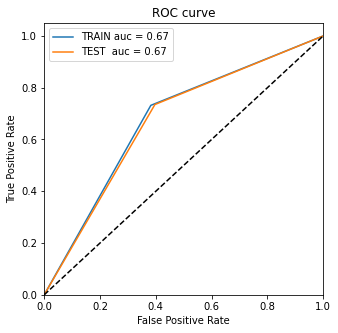

<Figure size 720x360 with 0 Axes>

In [524]:
# model sgd
grid_param = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
clf_sgd = SGDClassifier(random_state=678, class_weight='balanced', max_iter=200)
param_grid_sgd_classifier = {
    'loss': ['log'],
    'penalty': ['l1','l2', 'elasticnet', 'none'],
    'alpha': [10 ** x for x in range(-6, 1)],
    'l1_ratio': [0, 0.01, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.8, 0.9, 0.95, 1],
}
clf_sgd_grid = GridSearchCV(estimator=clf_sgd, param_grid=param_grid_sgd_classifier, n_jobs=-1, scoring='roc_auc', cv=5)
best_hyperparam_sgd_exp = clf_sgd_grid.fit(Xtrain, ytrain)
print(best_hyperparam_sgd_exp.best_estimator_.get_params())
clf_sgd_best_param_treatment = SGDClassifier(alpha=0.01, average= False, class_weight= 'balanced', early_stopping= False, 
                                             epsilon=0.1, eta0= 0.0, fit_intercept= True, l1_ratio= 0.15, 
                                             learning_rate= 'optimal', loss= 'log', max_iter= 200, n_iter_no_change= 5, 
                                             n_jobs= None, penalty= 'elasticnet', power_t= 0.5, random_state= 678,
                                             shuffle= True, tol= 0.001, validation_fraction= 0.1, verbose= 0, 
                                             warm_start= False)
clf_sgd_best_param_treatment.fit(Xtrain, ytrain)
clf_sgd_best_param_treatment.score(Xtrain, ytrain)
clf_sgd_best_param_treatment.score(Xtest, ytest)
roc_train=roc_auc_score(ytrain, clf_sgd_best_param_treatment.predict_proba(Xtrain)[:,1])
print('NLL Train Score = ',log_loss(ytrain, np.round(clf_sgd_best_param_treatment.predict_proba(Xtrain),2).tolist()))
roc_test=roc_auc_score(ytest, clf_sgd_best_param_treatment.predict_proba(Xtest)[:,1])
print('NLL Test Score = ',log_loss(ytest, np.round(clf_sgd_best_param_treatment.predict_proba(Xtest),2).tolist()))
# input result
model.append('sgd')
NLL_Train_score.append(log_loss(ytrain, np.round(clf_sgd_best_param_treatment.predict_proba(Xtrain),2).tolist()))
NLL_Test_score.append(log_loss(ytest, np.round(clf_sgd_best_param_treatment.predict_proba(Xtest),2).tolist()))
AUC_Train_score.append(roc_train)
AUC_Test_score.append(roc_test)
AUC_delta_score.append(abs(roc_train-roc_test))
times.append(time.time() - start_time)
#plot auc
fig,ax = plt.subplots(1)
fig.set_size_inches(5,5)
plot_auc(ax, 
         y_train=ytrain,y_train_pred=clf_sgd_best_param_treatment.predict_proba(Xtrain)[:,1], 
         y_test=ytest,y_test_pred=clf_sgd_best_param_treatment.predict_proba(Xtest)[:,1]
        )
plt.figure(figsize=(10,5))

Best Accuracy 0.7330472103004293
Best Param {'tol': 0.025, 'penalty': 'l2', 'loss': 'squared_hinge', 'C': 39}
NLL Train Score =  0.5519057167159339
NLL Test Score =  0.5407811298956384


<Figure size 720x360 with 0 Axes>

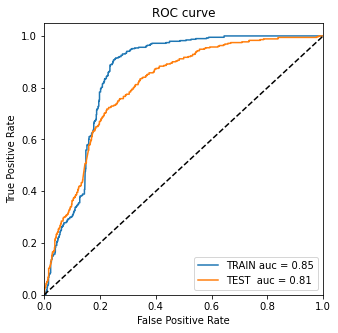

<Figure size 720x360 with 0 Axes>

In [525]:
def svm_fit(x_train, y_train):
    svm = LinearSVC()
    hyperparam = {'C': [i for i in range(100)],
                  'tol': [i/1000 for i in range(100)],
                  'loss':['squared_hinge','hinge'],
                  'penalty':['l1','l2'],
                 }
    random_svm = RandomizedSearchCV(svm, param_distributions = hyperparam, cv = 5,
                                    n_iter = 10, n_jobs=2, random_state = 123)
    
    random_svm.fit(Xtrain, ytrain)    
    print ("Best Accuracy", random_svm.best_score_)
    print ("Best Param", random_svm.best_params_)    
    return random_svm
best_svm = svm_fit(X, y) 
clf = LinearSVC(C=best_svm.best_params_.get('C'),
               tol=best_svm.best_params_.get('tol'),
               loss=best_svm.best_params_.get('loss'),
               penalty=best_svm.best_params_.get('penalty'))
svm = CalibratedClassifierCV(clf) 
svm.fit(Xtrain, ytrain)
roc_train=roc_auc_score(ytrain, svm.predict_proba(Xtrain)[:,1])
print('NLL Train Score = ',log_loss(ytrain, np.round(svm.predict_proba(Xtrain),2).tolist()))
roc_test=roc_auc_score(ytest, svm.predict_proba(Xtest)[:,1])
print('NLL Test Score = ',log_loss(ytest, np.round(svm.predict_proba(Xtest),2).tolist()))
# input result
model.append('svm')
NLL_Train_score.append(log_loss(ytrain, np.round(svm.predict_proba(Xtrain),2).tolist()))
NLL_Test_score.append(log_loss(ytest, np.round(svm.predict_proba(Xtest),2).tolist()))
AUC_Train_score.append(roc_train)
AUC_Test_score.append(roc_test)
AUC_delta_score.append(abs(roc_train-roc_test))
times.append(time.time() - start_time)

#plot auc
fig,ax = plt.subplots(1)
fig.set_size_inches(5,5)
plot_auc(ax, 
         y_train=ytrain,y_train_pred=svm.predict_proba(Xtrain)[:,1], 
         y_test=ytest,y_test_pred=svm.predict_proba(Xtest)[:,1]
        )
plt.figure(figsize=(10,5))

NLL Train Score =  0.2364894344025436
NLL Test Score =  0.6683366442698332


<Figure size 720x360 with 0 Axes>

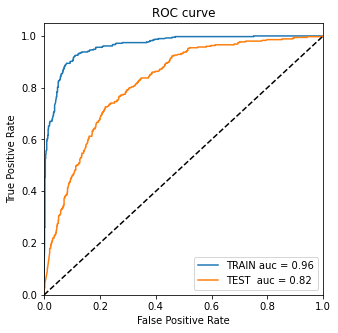

<Figure size 720x360 with 0 Axes>

In [526]:
# Initialize data
dftrains = pd.concat([Xtrain, ytrain],axis=1)
train_data = dftrains.drop('Y',axis=1) 
train_labels = dftrains['Y']
dftests = pd.concat([Xtest, ytest],axis=1)
test_data = dftests.drop('Y',axis=1) 
test_labels = dftests['Y']
# Initialize CatBoostClassifier
catboost = CatBoostClassifier(iterations=100,learning_rate=1,depth=2,verbose=False)
# Fit model
catboost.fit(train_data, train_labels)
#evaluation metrics
roc_train=roc_auc_score(train_labels, catboost.predict_proba(train_data)[:,1])
print('NLL Train Score = ',log_loss(train_labels, np.round(catboost.predict_proba(train_data),2).tolist()))
roc_test=roc_auc_score(test_labels, catboost.predict_proba(test_data)[:,1])
print('NLL Test Score = ',log_loss(test_labels, np.round(catboost.predict_proba(test_data),2).tolist()))
# input result
model.append('catboost')
NLL_Train_score.append(log_loss(train_labels, np.round(catboost.predict_proba(train_data),2).tolist()))
NLL_Test_score.append(log_loss(test_labels, np.round(catboost.predict_proba(test_data),2).tolist()))
AUC_Train_score.append(roc_train)
AUC_Test_score.append(roc_test)
AUC_delta_score.append(abs(roc_train-roc_test))
times.append(time.time() - start_time)

#plot auc
fig,ax = plt.subplots(1)
fig.set_size_inches(5,5)
plot_auc(ax, 
         y_train=train_labels, 
         y_train_pred=catboost.predict_proba(train_data)[:,1], 
         y_test=test_labels, 
         y_test_pred=catboost.predict_proba(test_data)[:,1]
        )
plt.figure(figsize=(10,5))

In [529]:
# plot delta score vs time
print("""From 8 model created a svm is choosen for final modelling due to having consistency score of 
NLL score and ROC score""")
eva = pd.DataFrame([model,
                    NLL_Train_score,NLL_Test_score,
                    AUC_Train_score,AUC_Test_score,
                    AUC_delta_score,times]).T.rename(columns={0:'model',
                                                              1:'NLL_Train_score',2:'NLL_Test_score',                                                              
                                                              3:'AUC_Train_score',4:'AUC_Test_score',
                                                              5:'AUC_delta_score',6:'times'})
eva['weighted_score'] = eva['AUC_delta_score']*eva['times']
eva.sort_values(by='weighted_score',ascending=True)

From 8 model created a svm is choosen for final modelling due to having consistency score of 
NLL score and ROC score


,model,NLL_Train_score,NLL_Test_score,AUC_Train_score,AUC_Test_score,AUC_delta_score,times,weighted_score
5,sgd,11.888454,12.33316,0.67486,0.669118,0.005741,23.071675,0.132461
0,Decision Tree,0.309272,1.263708,0.927847,0.810888,0.116959,2.340402,0.273731
1,randomforest,0.150174,0.920697,0.995504,0.817529,0.177975,3.852738,0.68569
4,logreg,0.554588,0.794116,0.787063,0.719975,0.067087,13.606713,0.912839
6,svm,0.551906,0.540781,0.850305,0.805862,0.044443,25.70354,1.142343
2,bagging,0.229416,0.827262,0.970119,0.819809,0.150309,10.809502,1.624769
3,adaboost,0.005611,8.065375,0.999959,0.802955,0.197003,11.152341,2.19705
7,catboost,0.236489,0.668337,0.962858,0.820677,0.14218,25.989705,3.695227


In [535]:
def plot_distr(data, train_or_test, label_actual='actual', label_proba='proba', n_sample=None):
    N = data.shape[0]
    listidx = data.index.values.tolist()
    disp = data.loc[listidx,:]
    disp = disp.rename({'pred':'ProbDefault'},axis=1)
    ax = sns.distplot(a=disp.loc[disp[label_actual]==1,label_proba], hist=True, color = 'Red', label='Event')
    ax = sns.distplot(a=disp.loc[disp[label_actual]==0,label_proba], hist=True, color = 'Green', label='NonEvent')
    ax.legend()
    ax = plt.title("Distribution between Event vs NonEvent")
def plot_ks(y_pred, y_true, N=10, bins=[], isplot=True):    
    result = pd.DataFrame({
        "predicted":y_pred,
        "Event":y_true.astype(int),
        "NonEvent":np.abs(1-y_true).astype(int)
    })
    result = result.sort_values(by='predicted', ascending=False)
    result['bucket'] = pd.qcut(result.predicted, q=N, labels=False, duplicates='drop')
    result['bucket'] = result['bucket'] + 1    
    display(result)
    grouped = result.groupby('bucket',as_index=False)    
    agg = pd.DataFrame({
        "min_prob":grouped.min().predicted, 
        "max_prob":grouped.max().predicted,
        "total":grouped.sum().NonEvent+grouped.sum().Event,
        "tot_Event": grouped.sum().Event,
        "tot_NonEvent":grouped.sum().NonEvent
    })
    agg = agg[['min_prob']+[x for x in agg.columns.values if x!='min_prob']]
    agg['pct_Event'] = (agg.tot_Event/agg.tot_Event.sum())
    agg['pct_NonEvent'] = (agg.tot_NonEvent/agg.tot_NonEvent.sum())
    agg['odds'] = (agg.tot_NonEvent / agg.tot_Event).apply('{0:.2f}'.format)
    agg['cum_Event'] = agg.pct_Event.cumsum()
    agg['cum_NonEvent'] = agg.pct_NonEvent.cumsum()
    agg['ks'] = np.abs(np.round(agg.cum_Event - agg.cum_NonEvent, 4))
    agg['max_ks'] = agg.ks.apply(lambda x: '<----' if x == agg.ks.max() else '')
    
    if isplot:    
        fig,ax = plt.subplots(1,1)
        fig.set_size_inches(15,5)
        ax.plot(agg.index.values, agg.cum_Event, color='red', label='Event')
        ax.plot(agg.index.values, agg.cum_NonEvent, color='green', label='NonEvent')
        plt.xticks(np.arange(0, N, N/10))
        _ = ax.set_xlabel('{} Buckets ordered by PD (Low-to-High)'.format(N))
        _ = ax.set_ylabel('Cumulative Event/NonEvent Rate (%)'.format(N))
        ax.legend()
        ks_max_idx = agg.ks.argmax()
        ks_max_NonEvent = agg.cum_NonEvent[ks_max_idx]
        ks_max_Event = agg.cum_Event[ks_max_idx]
        plt.annotate(s=''.format(agg.ks.max()), xy=(ks_max_idx,ks_max_NonEvent), xytext=(ks_max_idx,ks_max_Event), 
                     arrowprops=dict(arrowstyle='<->'))
        plt.text(ks_max_idx, ks_max_NonEvent, "KS={}".format(agg.ks.max()))    
    return agg

total number of churner =  98


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
date_of_churn,2018-11-22 00:00:00,2018-11-23 00:00:00,2018-11-24 00:00:00,2018-11-30 00:00:00,2018-12-01 00:00:00,2018-12-02 00:00:00,2018-12-03 00:00:00,2018-12-05 00:00:00,2018-12-07 00:00:00,2018-12-08 00:00:00,2018-12-09 00:00:00,2018-12-10 00:00:00,2018-12-11 00:00:00,2018-12-12 00:00:00,2018-12-14 00:00:00,2018-12-15 00:00:00,2018-12-16 00:00:00,2018-12-18 00:00:00,2018-12-19 00:00:00,2018-12-20 00:00:00,2018-12-21 00:00:00,2018-12-23 00:00:00,2018-12-24 00:00:00,2018-12-25 00:00:00,2018-12-26 00:00:00,2018-12-27 00:00:00,2018-12-28 00:00:00,2018-12-29 00:00:00,2018-12-30 00:00:00,2019-01-01 00:00:00,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-05 00:00:00,2019-01-06 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00,2019-01-11 00:00:00,2019-01-12 00:00:00,2019-01-13 00:00:00,2019-01-14 00:00:00,2019-01-15 00:00:00,2019-01-16 00:00:00,2019-01-17 00:00:00,2019-01-19 00:00:00,2019-01-20 00:00:00,2019-01-21 00:00:00,2019-01-23 00:00:00,2019-01-25 00:00:00,2019-01-26 00:00:00,2019-01-27 00:00:00,2019-01-28 00:00:00,2019-01-29 00:00:00,2019-01-31 00:00:00,2019-02-01 00:00:00,2019-02-03 00:00:00,2019-02-04 00:00:00,2019-02-06 00:00:00,2019-02-07 00:00:00,2019-02-08 00:00:00,2019-02-10 00:00:00,2019-02-12 00:00:00,2019-02-13 00:00:00,2019-02-14 00:00:00,2019-02-16 00:00:00,2019-02-17 00:00:00,2019-02-18 00:00:00,2019-02-19 00:00:00,2019-02-20 00:00:00,2019-02-22 00:00:00,2019-02-23 00:00:00,2019-02-24 00:00:00,2019-02-26 00:00:00,2019-02-27 00:00:00,2019-02-28 00:00:00,2019-03-01 00:00:00,2019-03-02 00:00:00,2019-03-03 00:00:00,2019-03-04 00:00:00,2019-03-05 00:00:00,2019-03-06 00:00:00,2019-03-07 00:00:00,2019-03-08 00:00:00,2019-03-09 00:00:00,2019-03-10 00:00:00,2019-03-11 00:00:00,2019-03-12 00:00:00,2019-03-13 00:00:00,2019-03-14 00:00:00,2019-03-15 00:00:00,2019-03-16 00:00:00,2019-03-17 00:00:00,2019-03-18 00:00:00,2019-03-19 00:00:00,2019-03-20 00:00:00,2019-03-21 00:00:00
num_of_churns,1,2,1,1,4,8,1,4,2,2,3,4,1,2,3,3,4,1,2,1,1,1,1,1,2,1,2,1,1,1,5,5,5,5,1,3,1,6,5,6,1,5,3,5,6,1,7,3,2,4,3,4,2,4,3,5,3,1,2,4,4,1,1,1,3,3,7,5,1,3,1,2,3,3,8,9,4,1,7,5,2,4,4,3,4,10,6,9,2,10,9,3,8,8,16,13,10,25


<AxesSubplot:xlabel='date_of_churn', ylabel='num_of_churns'>

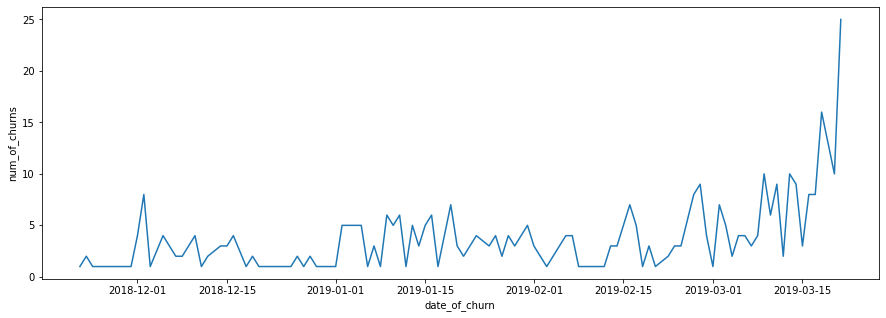

In [593]:
#predict churn
import datetime
test_data = pd.read_csv('test_data.csv',delimiter=',')
dfinit_test['prob_default'] = svm.predict_proba(Xtest)[:,1]
dfinit_test['pred_churn'] = np.where(dfinit_test['prob_default']>0.35,1,0)
dfpred = pd.merge(dfinit_test,test_data,how='inner',on='user_id')
dfpred['date_of_churn'] = pd.to_datetime(dfpred['last_trx_date'])+datetime.timedelta(days=21)
#number of churn each dates
df_churn = dfpred[['user_id','date_of_churn','pred_churn']].copy()
df_churn = df_churn[df_churn['pred_churn']==1]
df_churn = df_churn.groupby('date_of_churn',as_index=False)['user_id'].count().rename(columns={'user_id':'num_of_churns'})
df_churn = df_churn.sort_values('date_of_churn',ascending=True)
print('total number of churner = ',len(df_churn))
display(df_churn.T)
plt.figure(figsize=(15,5))
sns.lineplot(x='date_of_churn',y='num_of_churns',data = df_churn)

In [594]:
############## function to build risk and default rates by others features##############
def get_risk_rank_table(y_pred, y_true, N=10, bins=[], outstanding_amount=[]):
    os_amt = np.zeros(len(y_pred)) if len(outstanding_amount)==0 else np.double(outstanding_amount)
    result = pd.DataFrame({
        "predicted":y_pred,
        "osamount":os_amt,
        "Event":y_true.astype(int),
        "NonEvent":np.abs(1-y_true).astype(int),
        "Eventamount":y_true.astype(int) * os_amt,
        "NonEventamount":np.abs(1-y_true).astype(int) * os_amt
    })
    result = result.sort_values(by='predicted', ascending=False)
    if len(bins)>1:
        result['bucket'] = pd.cut(result['predicted'], bins=bins)
    else:
        result['bucket'] = pd.qcut(result.predicted, q=N, labels=False, duplicates='drop')
        result['bucket'] = result['bucket'] + 1
    grouped = result.groupby(['bucket'],as_index=False)    
    agg = pd.DataFrame({
    "Proba_MIN":grouped.min().predicted, 
    "Proba_MAX":grouped.max().predicted,
    "Total_Event": grouped.sum().Event,
    "Total_NonEvent":grouped.sum().NonEvent,
    "Total_Population":grouped.sum().NonEvent+grouped.sum().Event,
    "Total_Event_Amount":grouped.sum().Eventamount,
    "Total_NonEvent_Amount":grouped.sum().NonEventamount,
    "Total_Population_Amount":grouped.sum().osamount,
    })
    agg = agg[['Proba_MIN']+[x for x in agg.columns.values if x!='Proba_MIN']]
    
    agg['Rate_Event'] = (agg.Total_Event/agg.Total_Population)
    agg['Rate_NonEvent'] = (agg.Total_NonEvent/agg.Total_Population)
    agg['Cum_Rate_Event'] = agg.Total_Event.cumsum() / agg.Total_Population.cumsum()
    agg['Cum_Rate_NonEvent'] = agg.Total_NonEvent.cumsum() / agg.Total_Population.cumsum()
    agg['Cum_Rate_Appr_Rate'] = (agg.Total_Population.cumsum() / agg.Total_Population.sum())
    
    agg['Rate_Event_Amount'] = (agg.Total_Event_Amount / agg.Total_Population_Amount)
    agg['Rate_NonEvent_Amount'] = (agg.Total_NonEvent_Amount / agg.Total_Population_Amount)
    agg['Cum_Rate_Event_Amount'] = agg.Total_Event_Amount.cumsum() / agg.Total_Population_Amount.cumsum()
    agg['Cum_Rate_NonEvent_Amount'] = agg.Total_NonEvent_Amount.cumsum() / agg.Total_Population_Amount.cumsum()
    agg['Cum_Rate_Appr_Rate_Amount'] = (agg.Total_Population_Amount.cumsum() / agg.Total_Population_Amount.sum())
    
    if len(outstanding_amount)>0:
        agg = agg.loc[:,[
            'Proba_MIN','Proba_MAX',
            'Total_Population','Total_Event',
            'Cum_Rate_Appr_Rate','Rate_Event','Cum_Rate_Event',
            'Total_Population_Amount','Total_Event_Amount',
            'Cum_Rate_Appr_Rate_Amount','Rate_Event_Amount','Cum_Rate_Event_Amount'
        ]]
        agg = agg.rename({
            'Total_Population':'NoA_Population_Total',
            'Total_Event':'NoA_Event_Total',
            'Cum_Rate_Appr_Rate':'NoA_Approval_Rate',
            'Rate_Event':'NoA_Event_Rate',
            'Cum_Rate_Event':'NoA_Event_Rate_Cumulative',
            'Total_Population_Amount':'Amt_Population_Total',
            'Total_Event_Amount':'Amt_Event_Total',
            'Cum_Rate_Appr_Rate_Amount':'Amt_Approval_Rate',
            'Rate_Event_Amount':'Amt_Event_Rate',
            'Cum_Rate_Event_Amount':'Amt_Event_Rate_Cumulative'
        },axis=1)
    else:
        agg = agg.loc[:,[
            'Proba_MIN','Proba_MAX',
            'Total_Population','Total_Event',
            'Cum_Rate_Appr_Rate','Rate_Event','Cum_Rate_Event',
        ]]
        agg = agg.rename({
            'Total_Population':'NoA_Population_Total',
            'Total_Event':'NoA_Event_Total',
            'Cum_Rate_Appr_Rate':'NoA_Approval_Rate',
            'Rate_Event':'NoA_Event_Rate',
            'Cum_Rate_Event':'NoA_Event_Rate_Cumulative'
        },axis=1)
    
    return agg
tbl_early_warning_risk = get_risk_rank_table(dfinit_test['prob_default'], dfinit_test.Y, N=10, 
                                             outstanding_amount=dfinit_test.monthly_avg_net_amt)
# add columns grade
tbl_early_warning_risk['Grade'] = pd.Series(['A1', 'A2','A3', 'A4', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3'])
cols = list(tbl_early_warning_risk)
cols = [cols[-1]] + cols[:-1]
tbl_early_warning_risk = np.round(tbl_early_warning_risk[cols],2)
tbl_early_warning_risk

,Grade,Proba_MIN,Proba_MAX,NoA_Population_Total,NoA_Event_Total,NoA_Approval_Rate,NoA_Event_Rate,NoA_Event_Rate_Cumulative,Amt_Population_Total,Amt_Event_Total,Amt_Approval_Rate,Amt_Event_Rate,Amt_Event_Rate_Cumulative
0,A1,0.24,0.25,117,2,0.1,0.02,0.02,88184188.0,1051280.0,0.18,0.01,0.01
1,A2,0.25,0.26,116,6,0.2,0.05,0.03,114730778.0,4990260.0,0.41,0.04,0.03
2,A3,0.26,0.27,117,8,0.3,0.07,0.05,54050068.5,3981761.0,0.52,0.07,0.04
3,A4,0.27,0.28,116,19,0.4,0.16,0.08,41280186.5,5507306.0,0.60,0.13,0.05
4,B1,0.28,0.30,117,22,0.5,0.19,0.10,101303689.5,6891912.5,0.81,0.07,0.06
5,B2,0.30,0.33,116,36,0.6,0.31,0.13,27243894.0,11305813.5,0.86,0.41,0.08
6,B3,0.33,0.38,116,46,0.7,0.40,0.17,22872500.5,9298055.0,0.91,0.41,0.10
7,C1,0.38,0.43,117,74,0.8,0.63,0.23,33758657.0,31067980.5,0.98,0.92,0.15
8,C2,0.43,0.53,116,56,0.9,0.48,0.26,7039399.0,3274917.0,0.99,0.47,0.16
9,C3,0.53,0.67,117,82,1.0,0.70,0.30,4358444.5,3005717.0,1.00,0.69,0.16


In [595]:
tbl_early_warning_risk.to_csv('risk_rank.csv')

# Finish